In [1]:

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pickle
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


In [2]:
x =  np.load(r"dataset\Chip\train\X_long.npy")
y = np.load(r"dataset\Chip\train\y_long.npy")


x_val = np.load(r"dataset\Chip\validation\X_long.npy")
y_val = np.load(r"dataset\Chip\validation\y_long.npy")

x_test = np.load(r"dataset\Chip\test\X_long.npy")
y_test = np.load(r"dataset\Chip\test\y_long.npy")

x = x[:,:,200:800]
x_val = x_val[:,:,200:800]
x_test = x_test[:,:,200:800]

print(f'X shape: {x.shape} y shape: {y.shape}')
print(f'X_val shape: {x_val.shape} y_val shape: {y_val.shape}')
print(f'X_test shape: {x_test.shape} y_test shape: {y_test.shape}')


# === Load EMG dicts ===
with open("dataset/Chip/train/y_emg_dict.pkl", "rb") as f:
    y_emg = pickle.load(f)
with open("dataset/Chip/validation/y_emg_dict.pkl", "rb") as f:
    y_emg_val = pickle.load(f)
with open("dataset/Chip/test/y_emg_dict.pkl", "rb") as f:
    y_emg_test = pickle.load(f)

# === Extract muscle list and build aligned EMG arrays ===
muscles = sorted({k for trial in y_emg for k in trial})
n_muscles = len(muscles)
emg_bins = 1250


keys = []
for i in range(len(y_emg)):
    keys.append(list(y_emg[i].keys()))
for i in range(len(y_emg_val)):
    keys.append(list(y_emg_val[i].keys()))
for i in range(len(y_emg_test)):
    keys.append(list(y_emg_test[i].keys()))

# find which keys are common in all trials
common_keys = set(keys[0])
for i in range(1, len(keys)):
    common_keys.intersection_update(set(keys[i]))
print(f"Common keys: {common_keys}")
# remove uncommon keys from y_emg , y_emg_val, y_emg_test
for i in range(len(y_emg)):
    for key in list(y_emg[i].keys()):
        if key not in common_keys:
            del y_emg[i][key]
for i in range(len(y_emg_val)):
    for key in list(y_emg_val[i].keys()):
        if key not in common_keys:
            del y_emg_val[i][key]
for i in range(len(y_emg_test)):
    for key in list(y_emg_test[i].keys()):
        if key not in common_keys:
            del y_emg_test[i][key]
# === Check if all trials have the same keys ===
for i in range(len(y_emg)):
    if set(y_emg[i].keys()) != common_keys:
        print(f"Trial {i} has different keys")
# === Check if all trials have the same keys ===
for i in range(len(y_emg_val)):
    if set(y_emg_val[i].keys()) != common_keys:
        print(f"Trial {i} has different keys")
# === Check if all trials have the same keys ===
for i in range(len(y_emg_test)):
    if set(y_emg_test[i].keys()) != common_keys:
        print(f"Trial {i} has different keys")

# Ensure the channel (muscle) order is the same across all labels and create a corresponding dict

# Sort the common_keys to define a consistent channel order
ordered_muscles = sorted(list(common_keys))

# Create a mapping from index to muscle name
muscle_idx_dict = {i: muscle for i, muscle in enumerate(ordered_muscles)}
print("Muscle index mapping:", muscle_idx_dict)

def emg_dicts_to_tensor(y_dicts, muscles, emg_bins):
    Y = np.zeros((len(y_dicts), len(muscles), emg_bins), dtype=np.float32)
    for i, trial in enumerate(y_dicts):
        for j, muscle in enumerate(muscles):
            if muscle in trial:
                Y[i, j, :] = trial[muscle]
                # center baseline to zero
                Y[i, j, :] -= np.mean(Y[i, j, :200])
            else:
                # If a muscle is missing, fill with zeros (should not happen after filtering)
                Y[i, j, :] = 0
    return Y

del keys, common_keys, n_muscles, muscles

# Now use ordered_muscles instead of muscles everywhere
y = emg_dicts_to_tensor(y_emg, ordered_muscles, emg_bins)[:, :, 200:800]
y_val = emg_dicts_to_tensor(y_emg_val, ordered_muscles, emg_bins)[:, :, 200:800]
y_test = emg_dicts_to_tensor(y_emg_test, ordered_muscles, emg_bins)[:, :, 200:800]


# clear memory
del y_emg, y_emg_val, y_emg_test , emg_bins , ordered_muscles
print('cleared memory')




X shape: (600, 152, 600) y shape: (600,)
X_val shape: (600, 152, 600) y_val shape: (600,)
X_test shape: (600, 152, 600) y_test shape: (600,)
Common keys: {'ED45', 'FDPr', 'EDC', 'ED23', 'ECR', 'FDPu', 'FDS'}
Muscle index mapping: {0: 'ECR', 1: 'ED23', 2: 'ED45', 3: 'EDC', 4: 'FDPr', 5: 'FDPu', 6: 'FDS'}
cleared memory


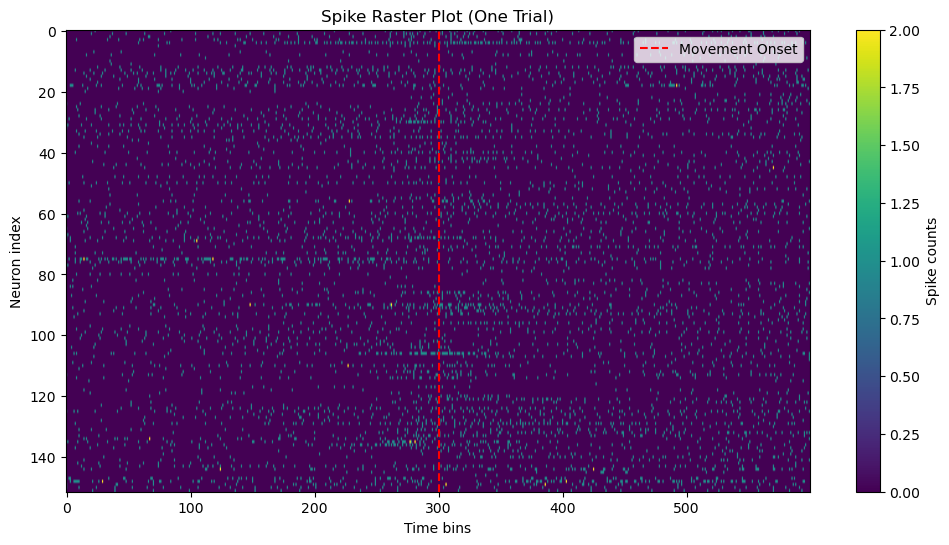

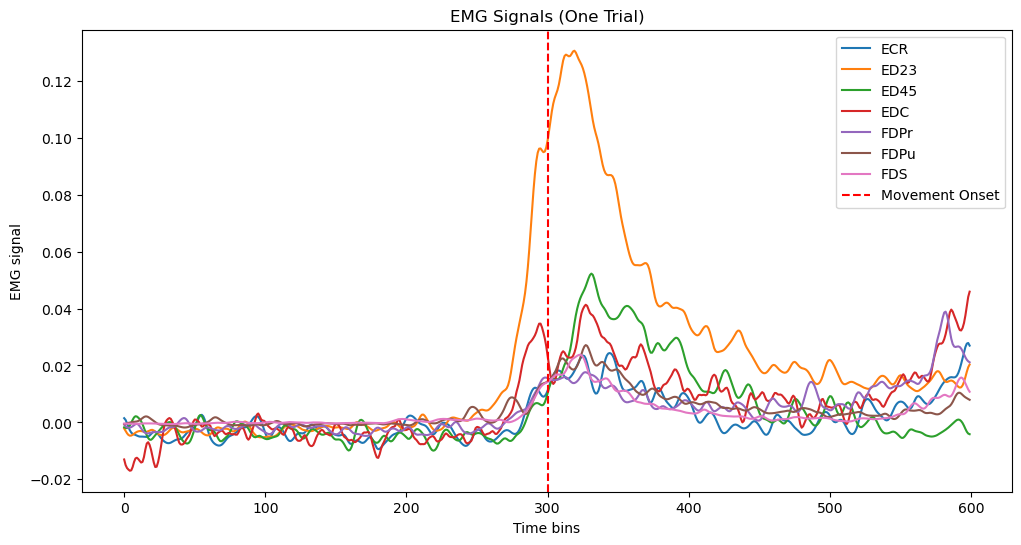

In [3]:
# plot first trail for all neurons
i = 100
plt.figure(figsize=(12, 6))
plt.imshow(x[i], aspect='auto', cmap='viridis')
plt.colorbar(label='Spike counts')
plt.axvline(x=300, color='red', linestyle='--', label='Movement Onset')
plt.legend()
plt.xlabel('Time bins')
plt.ylabel('Neuron index')
plt.title('Spike Raster Plot (One Trial)')
plt.show()

# plot first trail for all muscles
plt.figure(figsize=(12, 6))
for j in range(len(list(muscle_idx_dict.keys()))):
    plt.plot(y[i, j], label=muscle_idx_dict[j])
plt.axvline(x=300, color='red', linestyle='--', label='Movement Onset')
plt.legend()
plt.xlabel('Time bins')
plt.ylabel('EMG signal')
plt.title('EMG Signals (One Trial)')
plt.show()



In [4]:
class SpikeToEMGDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

train_ds = SpikeToEMGDataset(x, y)
val_ds = SpikeToEMGDataset(x_val, y_val)
test_ds = SpikeToEMGDataset(x_test, y_test)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)
test_loader = DataLoader(test_ds, batch_size=32)


In [5]:
class SpikeConvToEMG(nn.Module):
    def __init__(self, n_neurons, n_muscles, emg_bins):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(n_neurons, 64, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(128, 128, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Conv1d(128, n_muscles, kernel_size=1),
            nn.Upsample(size=emg_bins, mode='linear', align_corners=True)
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

# Model instantiation
model = SpikeConvToEMG(n_neurons=x.shape[1], n_muscles=y.shape[1], emg_bins=y.shape[2])


In [6]:
movement_names = ['1e', '1f', '2e', '2f', '3e', '3f', '4e', '4f', '5e', '5f', '6e', '6f']
      
def plot_muscle_predictions_tensor(yb, pred, muscle_idx_dict, val_loader=None):
    n_muscles = yb.shape[1]
    n_time = yb.shape[2]
    # Get global min/max for axis limits
    y_min = min(yb[0].min().cpu().item(), pred[0].min().cpu().item())
    y_max = max(yb[0].max().cpu().item(), pred[0].max().cpu().item())

    # Use a color palette for muscles
    colors = plt.cm.tab10.colors if n_muscles <= 10 else plt.cm.tab20.colors

    # Get movement name if available
    movement_names = ['1e', '1f', '2e', '2f', '3e', '3f', '4e', '4f', '5e', '5f', '6e', '6f']
    if y_val is not None and hasattr(yb, "device"):
        # Try to get the movement index for the current trial
        # yb shape: [batch, n_muscles, n_time], y_val shape: [n_trials, n_muscles, n_time]
        # We assume the batch index i*batch_size + 0 corresponds to the trial index
        # For this dataset, movement index is trial_idx // 50
        movement_idx = None
        if hasattr(val_loader, 'batch_size') and val_loader.batch_size is not None:
            trial_idx = i * val_loader.batch_size
            if trial_idx < y_val.shape[0]:
                movement_idx = trial_idx // 50
            else:
                movement_idx = None
        else:
            movement_idx = None
        movement_idx = None
        if hasattr(val_loader, 'batch_size') and val_loader.batch_size is not None:
            trial_idx = i * val_loader.batch_size
            if trial_idx < y_val.shape[0]:
                movement_idx = np.argmax(np.abs(y_val[trial_idx, :, :]).sum(axis=1))
            else:
                movement_idx = None
        else:
            movement_idx = None
        # If y_val is [n_trials, n_muscles, n_time], try to get the movement index for the first trial in the batch
        if movement_idx is not None and movement_idx < len(movement_names):
            movement_title = f"Movement: {movement_names[movement_idx]}"
        else:
            movement_title = ""
    else:
        movement_title = ""

    fig, axs = plt.subplots(n_muscles, 1, figsize=(14, 2.2 * n_muscles), sharex=True)
    if n_muscles == 1:
        axs = [axs]
    for j in range(n_muscles):
        std = torch.std(yb[0, j], dim=0, keepdim=True)
        axs[j].plot(yb[0, j].cpu().numpy(), label='Ground Truth', color='black', linewidth=1.5)
        axs[j].plot(pred[0, j].cpu().numpy(), label='Prediction', color=colors[j % len(colors)], alpha=0.8, linewidth=1.5)
        axs[j].axvline(x=300, color='red', linestyle='--', label='Movement Onset' if j == 0 else None)
        axs[j].set_ylabel(muscle_idx_dict[j])
        axs[j].set_title(f"Muscle: {muscle_idx_dict[j]}, std: {std.cpu().item():.2f}", fontsize=10)
        axs[j].set_ylim(y_min, y_max)
        if j == 0:
            axs[j].legend()
    axs[-1].set_xlabel('Time bins')
    plt.suptitle(f'EMG Prediction vs Ground Truth (One Trial, Each Muscle)\n{movement_title}', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()

def plot_loss_curves(train_loss_vec, val_loss_vec, train_mse_vec, val_mse_vec,  lr_vec):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 5))
    plt.plot(train_loss_vec, label='Train Loss')
    plt.plot(val_loss_vec, label='Validation Loss')
    plt.plot(train_mse_vec, label='Train MSE')
    plt.plot(val_mse_vec, label='Validation MSE')
    plt.plot([lr * 10 for lr in lr_vec], label='Learning Rate')

    if len(val_loss_vec) > 0:
        best_epoch = np.argmin(val_loss_vec)
        plt.scatter(best_epoch, val_loss_vec[best_epoch], color='orange', label='Best Val Loss')
        plt.annotate(f'{val_loss_vec[best_epoch]:.3e}', (best_epoch, val_loss_vec[best_epoch]),
                     textcoords="offset points", xytext=(0,10), ha='center', color='orange')
    if len(val_mse_vec) > 0:
        best_epoch = np.argmin(val_mse_vec)
        plt.scatter(best_epoch, val_mse_vec[best_epoch], color='blue', label='Best Val MSE')
        plt.annotate(f'{val_mse_vec[best_epoch]:.3e}', (best_epoch, val_mse_vec[best_epoch]),
                     textcoords="offset points", xytext=(0,10), ha='center', color='blue')
        
    plt.title('Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()


In [538]:
import os
n_epochs = 50
checkpoint_interval = 5  # save every k epochs
checkpoint_dir = "model_2_checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# Model instantiation
model = SpikeConvToEMG(n_neurons=x.shape[1], n_muscles=y.shape[1], emg_bins=y.shape[2])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.5)

# === Metric Tracking ===
train_loss_vec = []
val_loss_vec = []
train_mse_vec = []
val_mse_vec = []
lr_vec = []


# === Custom Weighted MSE Loss ===
def weighted_mse(pred, true):
    error = (pred - true) ** 2
    std = torch.std(true, dim=2, keepdim=True)
    std = std / torch.sum(std, dim=1, keepdim=True)
    weighted_error = error * (1 + std)
    return torch.mean(weighted_error)

# === Training Loop ===
for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    total_mse = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        loss = weighted_mse(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_mse += torch.mean((pred - yb) ** 2)
        
    
    avg_train_loss = total_loss / len(train_loader)
    train_loss_vec.append(avg_train_loss)
    avg_train_mse = total_mse / len(train_loader)
    train_mse_vec.append(total_mse.item())
    # === Validation MSE ===

    
    # === Validation Loss ===
    model.eval()
    with torch.no_grad():
        val_total_loss = 0
        for xb_val, yb_val in val_loader:
            xb_val, yb_val = xb_val.to(device), yb_val.to(device)
            pred_val = model(xb_val)
            val_loss = weighted_mse(pred_val, yb_val)
            val_total_loss += val_loss.item()
        avg_val_loss = val_total_loss / len(val_loader)
        val_loss_vec.append(avg_val_loss)
        val_mse = torch.mean(((pred_val[:,:,200:400] - yb_val[:,:,200:400]) ** 2))
        val_mse_vec.append(val_mse.item())
        
    print(f"Epoch {epoch+1:02d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} , LR: {lr_scheduler.get_last_lr()[0]:.6f}")   
    lr_vec.append(lr_scheduler.get_last_lr()[0])
    lr_scheduler.step()
    # save if best val mse 
    if len(val_mse_vec) > 0:
        if val_mse_vec[-1] == min(val_mse_vec):
            best_epoch = epoch + 1
            #save model
            torch.save(model.state_dict(), os.path.join(checkpoint_dir, "best_model.pth"))
    # === Save Checkpoint ===
    if (epoch + 1) % checkpoint_interval == 0 or epoch == n_epochs - 1:
        ckpt_path = os.path.join(checkpoint_dir, f"{str(epoch+1).zfill(4)}_epoch_checkpoint.pth")
        torch.save(model.state_dict(), ckpt_path)
        print(f"✅ Saved checkpoint: {ckpt_path}")


print(f"Best epoch: {best_epoch}")
# Load the best model
model.load_state_dict(torch.load(os.path.join(checkpoint_dir, "best_model.pth")))



Epoch 01 | Train Loss: 0.0017 | Val Loss: 0.0020 , LR: 0.001000
Epoch 02 | Train Loss: 0.0009 | Val Loss: 0.0015 , LR: 0.001000
Epoch 03 | Train Loss: 0.0006 | Val Loss: 0.0012 , LR: 0.001000
Epoch 04 | Train Loss: 0.0004 | Val Loss: 0.0011 , LR: 0.001000
Epoch 05 | Train Loss: 0.0003 | Val Loss: 0.0010 , LR: 0.001000
✅ Saved checkpoint: model_2_checkpoints\0005_epoch_checkpoint.pth
Epoch 06 | Train Loss: 0.0003 | Val Loss: 0.0010 , LR: 0.001000
Epoch 07 | Train Loss: 0.0002 | Val Loss: 0.0010 , LR: 0.000500
Epoch 08 | Train Loss: 0.0002 | Val Loss: 0.0009 , LR: 0.000500
Epoch 09 | Train Loss: 0.0002 | Val Loss: 0.0009 , LR: 0.000500
Epoch 10 | Train Loss: 0.0002 | Val Loss: 0.0009 , LR: 0.000500
✅ Saved checkpoint: model_2_checkpoints\0010_epoch_checkpoint.pth
Epoch 11 | Train Loss: 0.0002 | Val Loss: 0.0009 , LR: 0.000500
Epoch 12 | Train Loss: 0.0002 | Val Loss: 0.0009 , LR: 0.000500
Epoch 13 | Train Loss: 0.0002 | Val Loss: 0.0009 , LR: 0.000250
Epoch 14 | Train Loss: 0.0002 | Val 

C:\Users\cathalert\AppData\Local\Temp\ipykernel_37276\801248058.py:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(checkpoint

<All keys matched successfully>

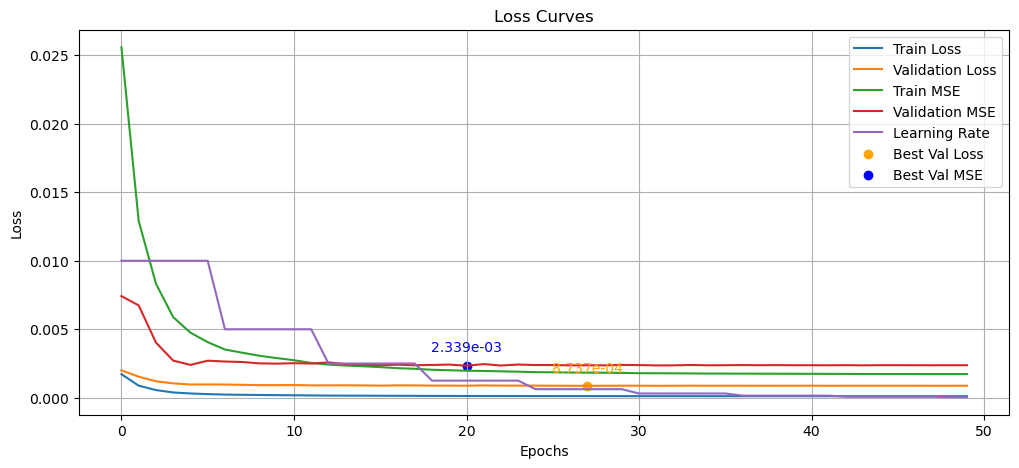

In [539]:
plot_loss_curves(train_loss_vec, val_loss_vec, train_mse_vec, val_mse_vec, lr_vec)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


0005_epoch_checkpoint.pth


C:\Users\cathalert\AppData\Local\Temp\ipykernel_4388\3137465830.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(folder, ch

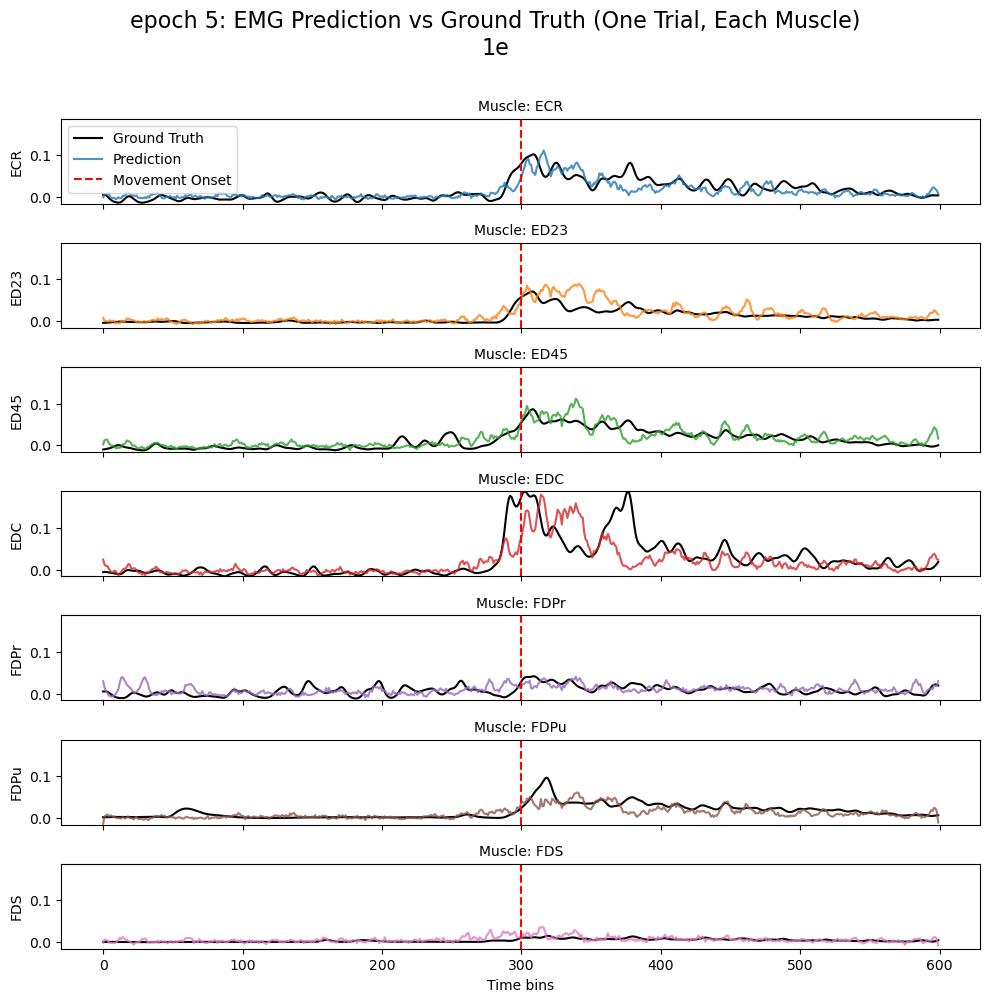

0010_epoch_checkpoint.pth


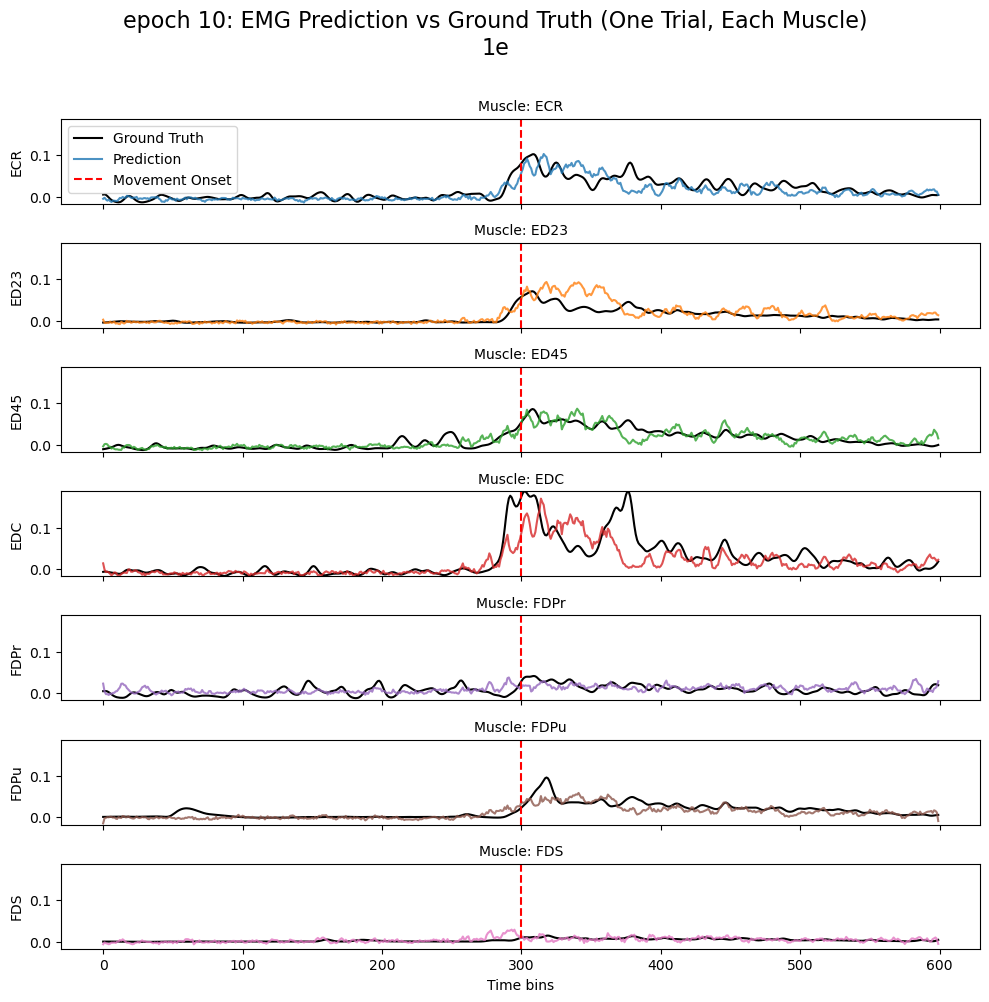

0015_epoch_checkpoint.pth


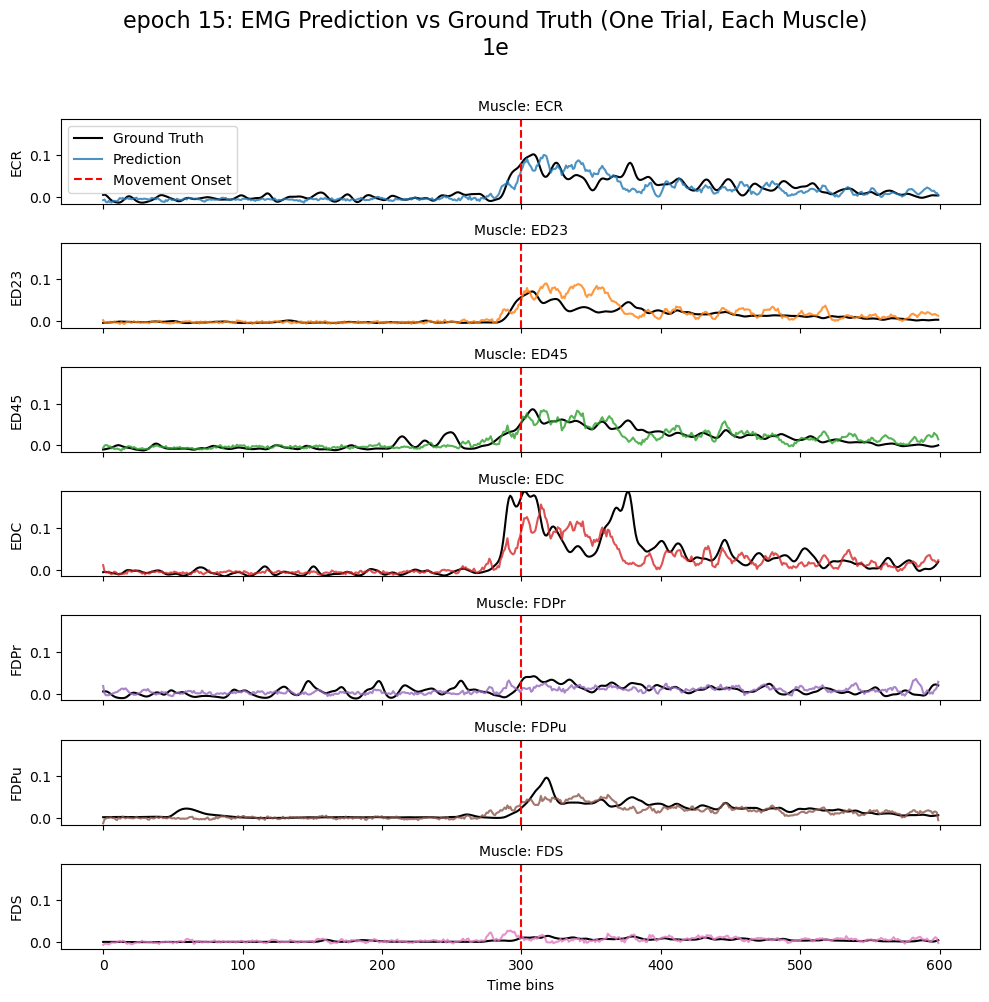

0020_epoch_checkpoint.pth


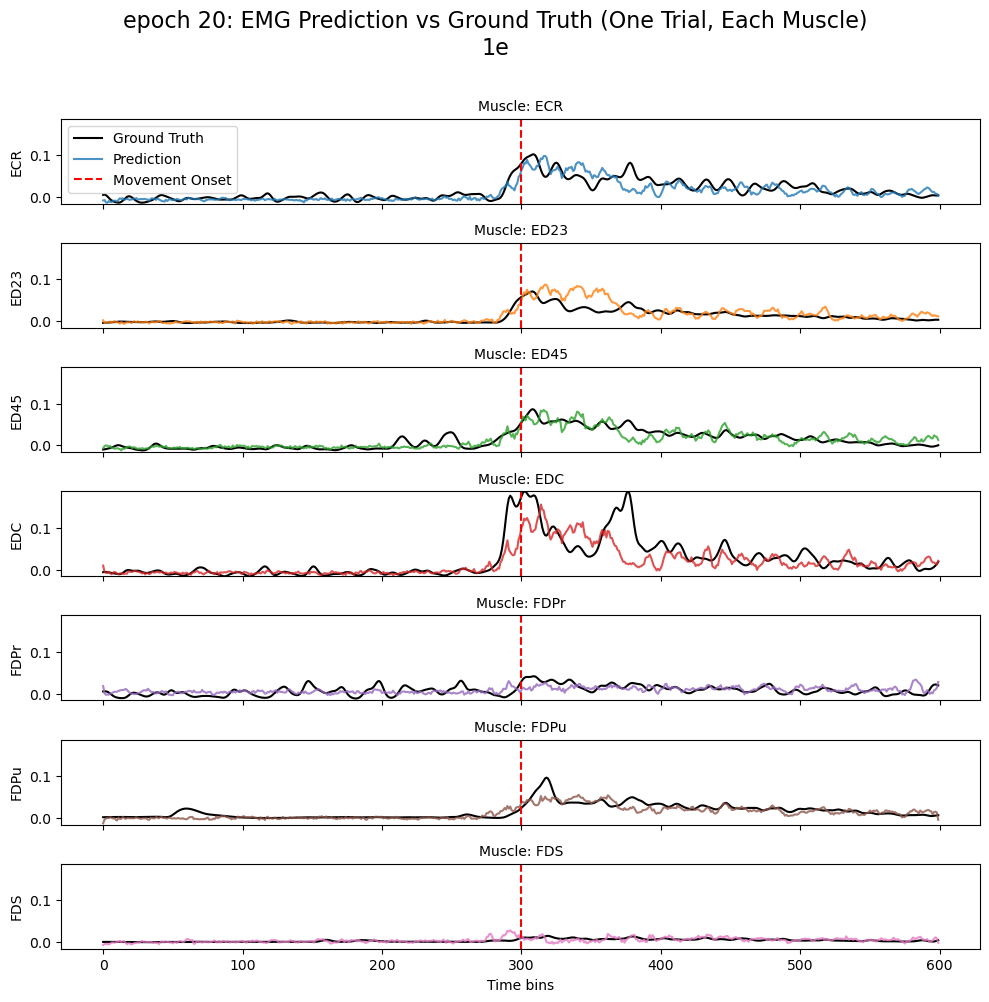

0025_epoch_checkpoint.pth


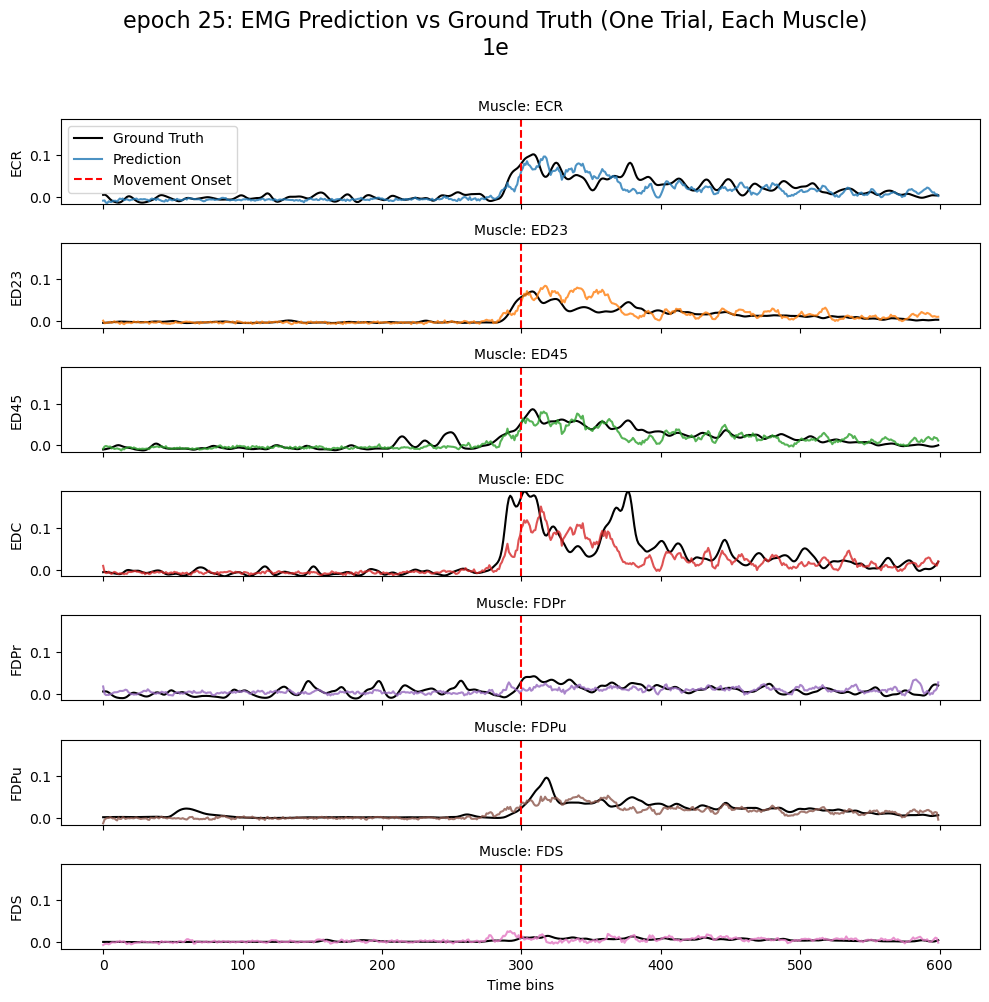

0030_epoch_checkpoint.pth


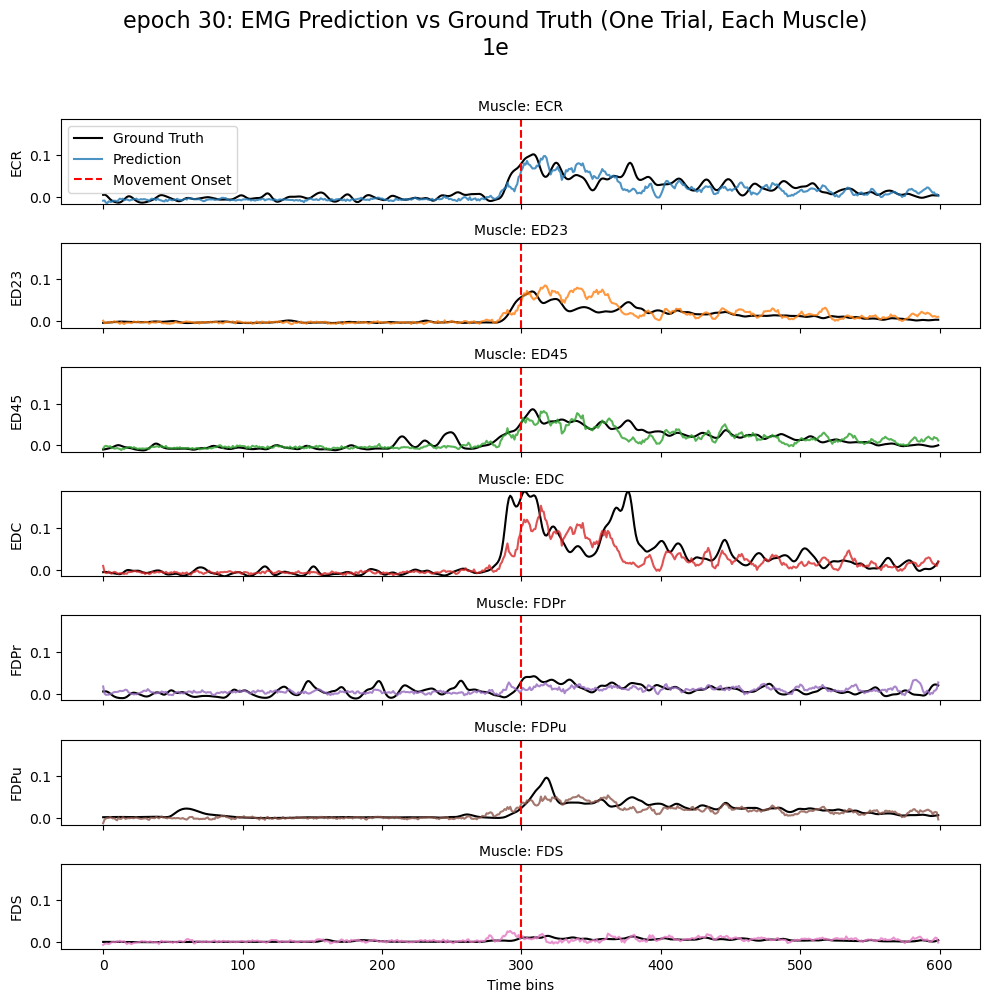

0035_epoch_checkpoint.pth


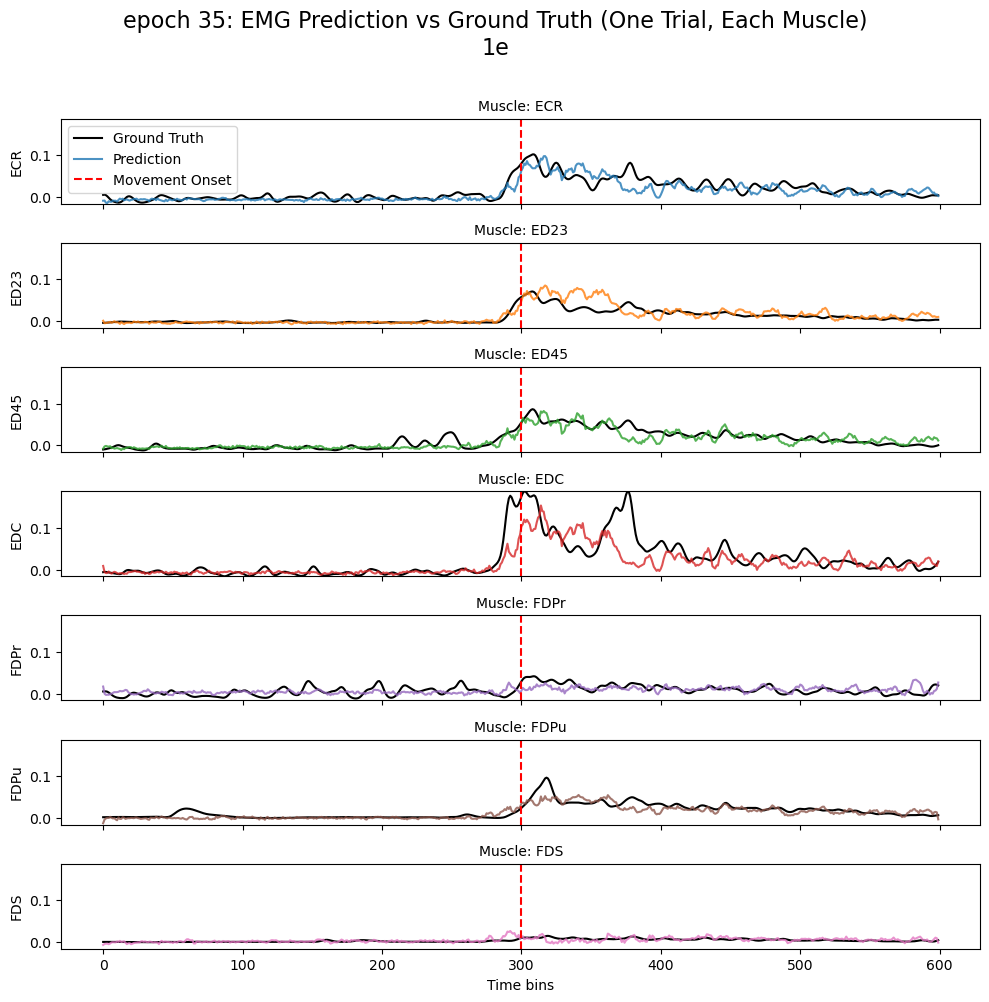

0040_epoch_checkpoint.pth


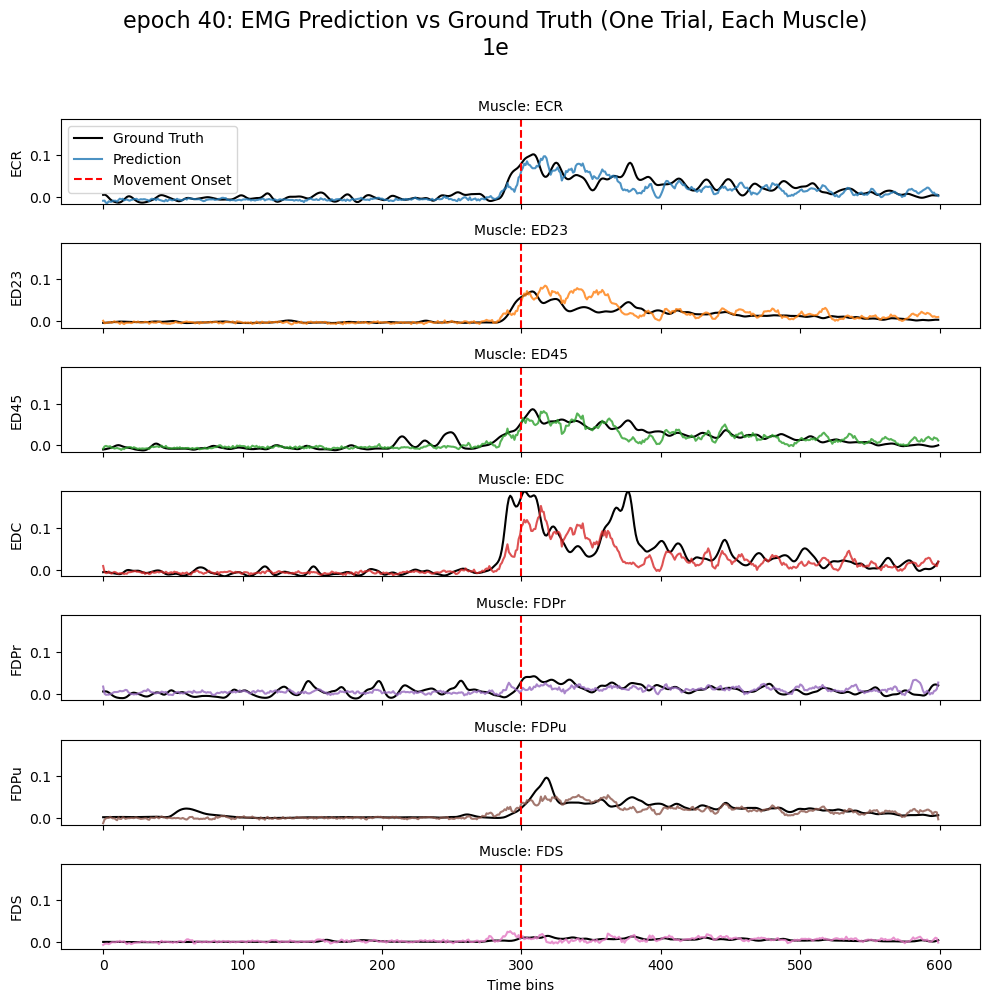

0045_epoch_checkpoint.pth


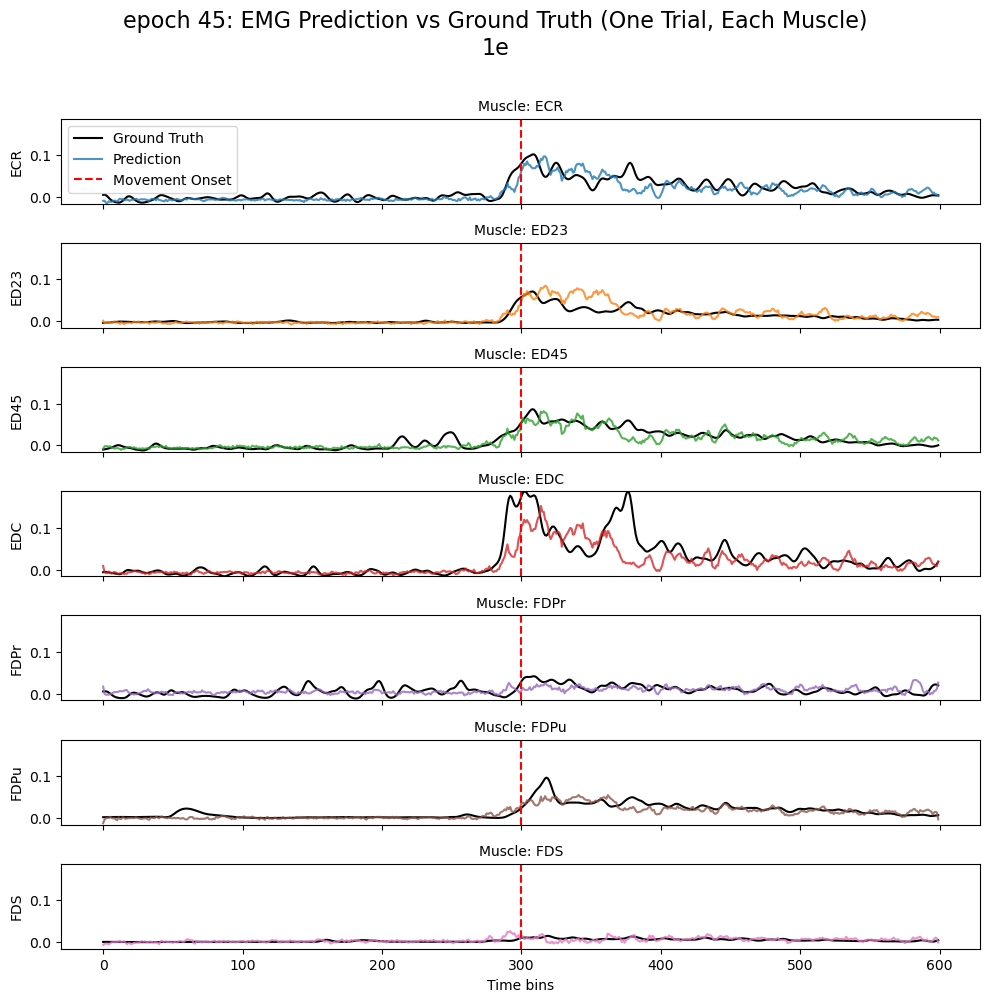

0050_epoch_checkpoint.pth


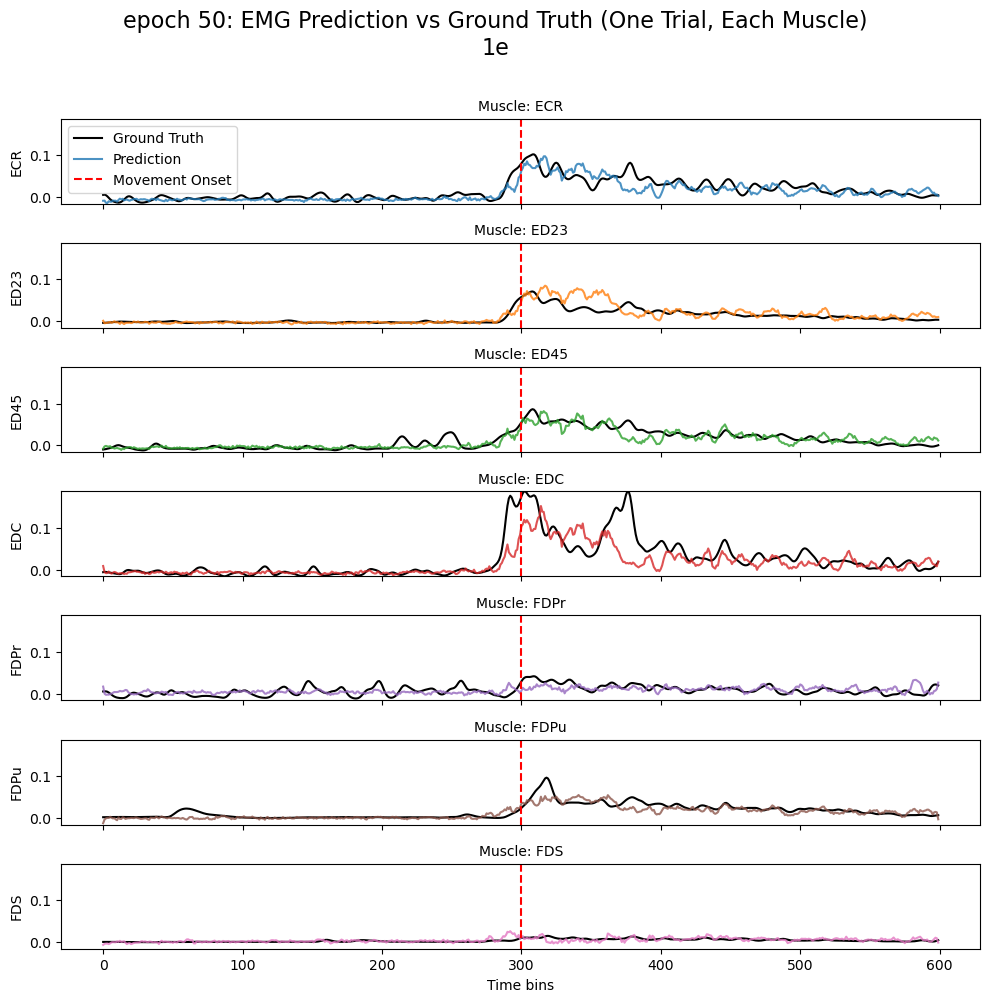

best_model.pth


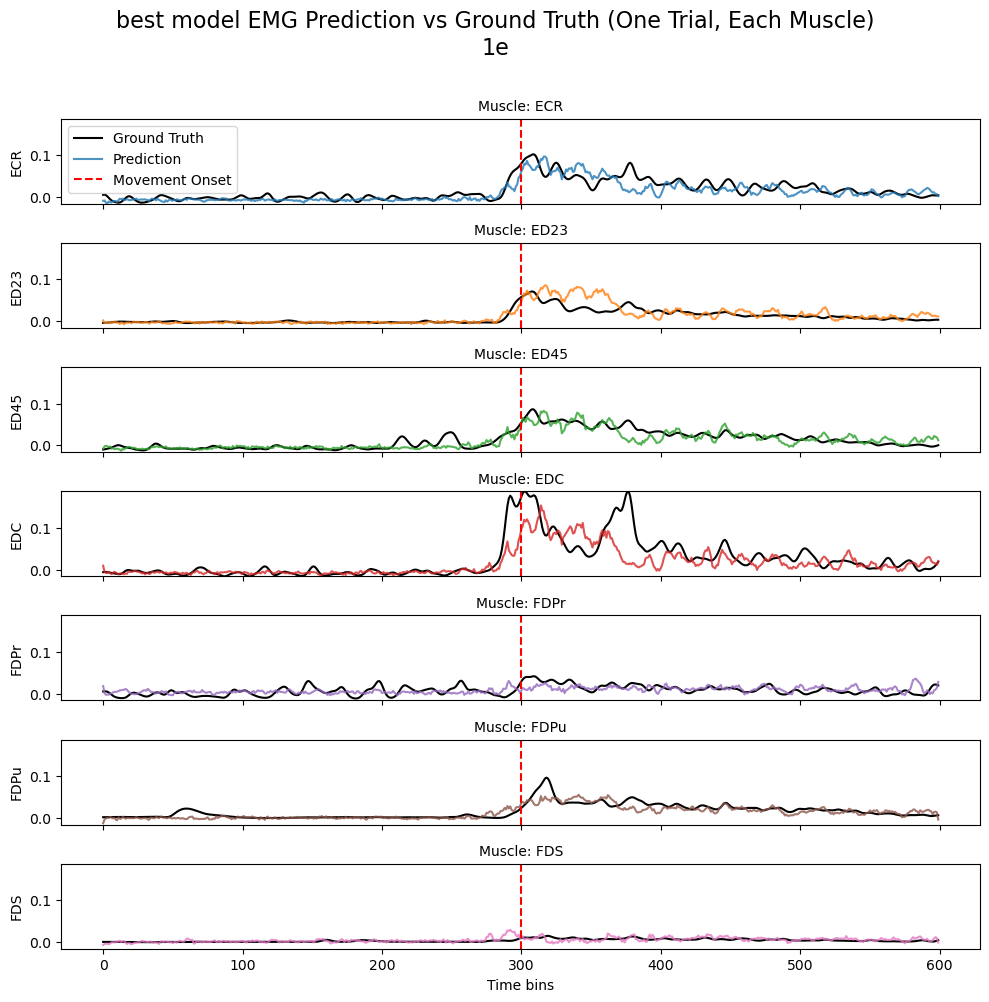

In [8]:
sample_index = 1
sample_movement = movement_names[sample_index // 50]
x_s = x_val[sample_index]
y_s = y_val[sample_index]
y_s = y_s.reshape(1, y_s.shape[0], y_s.shape[1])
x_s = torch.tensor(x_s, dtype=torch.float32).unsqueeze(0).to(device)
y_s = torch.tensor(y_s, dtype=torch.float32).to(device)
y_s = y_s.cpu().numpy()

folder = "model_2_checkpoints"
for chkp in os.listdir(folder):
    if chkp.endswith(".pth"):
        print(chkp)
        model.load_state_dict(torch.load(os.path.join(folder, chkp)))
        model.eval()
        with torch.no_grad():
            pred = model(x_s)
        pred = pred.cpu().numpy()
        
        # plot it!
        n_muscles = y_s.shape[1]
        n_time = y_s.shape[2]
        # Get global min/max for axis limits
        y_min = min(y_s[0].min(), pred[0].min())
        y_max = max(y_s[0].max(), pred[0].max())

        # Use a color palette for muscles
        colors = plt.cm.tab10.colors if n_muscles <= 10 else plt.cm.tab20.colors
        
        fig, axs = plt.subplots(n_muscles, 1, figsize=(10, 1.5 * n_muscles), sharex=True)
        if n_muscles == 1:
            axs = [axs]
        for j in range(n_muscles):
            axs[j].plot(y_s[0, j], label='Ground Truth', color='black', linewidth=1.5)
            axs[j].plot(pred[0, j], label='Prediction', color=colors[j % len(colors)], alpha=0.8, linewidth=1.5)
            axs[j].axvline(x=300, color='red', linestyle='--', label='Movement Onset' if j == 0 else None)
            axs[j].set_ylabel(muscle_idx_dict[j])
            axs[j].set_title(f"Muscle: {muscle_idx_dict[j]}", fontsize=10)
            axs[j].set_ylim(y_min, y_max)
            if j == 0:
                axs[j].legend()
        axs[-1].set_xlabel('Time bins')
        if chkp != "best_model.pth":
            plt.suptitle(f'epoch {str(int(chkp[:4]))}: EMG Prediction vs Ground Truth (One Trial, Each Muscle)\n{sample_movement}', fontsize=16)
        else:
            plt.suptitle(f'best model EMG Prediction vs Ground Truth (One Trial, Each Muscle)\n{sample_movement}', fontsize=16)

        plt.tight_layout(rect=[0, 0.03, 1, 0.97])
        plt.show()
        




# bigger larger greater


In [541]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, padding=padding)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=kernel_size, padding=padding)
        self.downsample = None
        if in_channels != out_channels:
            self.downsample = nn.Conv1d(in_channels, out_channels, kernel_size=1)
        
    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)
        if self.downsample is not None:
            identity = self.downsample(identity)
        out += identity
        out = self.relu(out)
        return out

class SpikeConvToEMG_BIG(nn.Module):
    def __init__(self, n_neurons, n_muscles, emg_bins):
        super().__init__()
        self.encoder = nn.Sequential(
            ResidualBlock(n_neurons, 64, kernel_size=7, padding=3),
            ResidualBlock(64, 128, kernel_size=5, padding=2),
            ResidualBlock(128, 128, kernel_size=3, padding=1)
        )
        self.decoder = nn.Sequential(
            nn.Conv1d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            ResidualBlock(128, 128, kernel_size=3, padding=1),
            nn.Conv1d(128, n_muscles, kernel_size=1),
            nn.Upsample(size=emg_bins, mode='linear', align_corners=True)
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

model = SpikeConvToEMG_BIG(n_neurons=x.shape[1], n_muscles=y.shape[1], emg_bins=y.shape[2])


In [542]:
import os
n_epochs = 50
checkpoint_interval = 5  # save every k epochs
checkpoint_dir = "model_2_big_checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# Model instantiation
model = SpikeConvToEMG_BIG(n_neurons=x.shape[1], n_muscles=y.shape[1], emg_bins=y.shape[2])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# === Metric Tracking ===
train_loss_vec = []
val_loss_vec = []
lr_vec = []
train_mse_vec = []
val_mse_vec = []

# === Custom Weighted MSE Loss ===
def weighted_mse_by_std(pred, true):
    error = (pred - true) ** 2
    std = torch.std(true[:,:,200:500], dim=2, keepdim=True)
    std = std / torch.sum(std, dim=1, keepdim=True)
    weighted_error = error * ( 1 + std )
    return torch.mean(weighted_error)

# === Training Loop ===
for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    total_mse = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        loss = weighted_mse_by_std(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        mse = torch.mean((pred - yb) ** 2)
        total_mse += mse.item()

    
    avg_train_loss = total_loss / len(train_loader)
    train_loss_vec.append(avg_train_loss)
    avg_train_mse = total_mse / len(train_loader)
    train_mse_vec.append(avg_train_mse)
    
    # === Validation Loss ===
    model.eval()
    with torch.no_grad():
        val_total_loss = 0
        for xb_val, yb_val in val_loader:
            xb_val, yb_val = xb_val.to(device), yb_val.to(device)
            pred_val = model(xb_val)
            val_loss = weighted_mse(pred_val, yb_val)
            val_total_loss += val_loss.item()
        avg_val_loss = val_total_loss / len(val_loader)
        val_loss_vec.append(avg_val_loss)
        val_mse = torch.mean((pred_val - yb_val) ** 2)
        val_mse_vec.append(val_mse.item())
        
    print(f"Epoch {epoch+1:02d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} , LR: {lr_scheduler.get_last_lr()[0]:.6f}")   
    lr_vec.append(lr_scheduler.get_last_lr()[0])
    lr_scheduler.step()

    #save if best val mse
    if len(val_mse_vec) > 0:
        if val_mse_vec[-1] == min(val_mse_vec):
            best_epoch = epoch + 1
            #save model
            torch.save(model.state_dict(), os.path.join(checkpoint_dir, "best_model.pth"))


    # === Save Checkpoint ===
    if (epoch + 1) % checkpoint_interval == 0 or epoch == n_epochs - 1:
        ckpt_path = os.path.join(checkpoint_dir, f"{str(epoch+1).zfill(4)}_epoch_checkpoint.pth")
        torch.save(model.state_dict(), ckpt_path)
        print(f"✅ Saved checkpoint: {ckpt_path}")

print(f"Best epoch: {best_epoch}")
# Load the best model
model.load_state_dict(torch.load(os.path.join(checkpoint_dir, "best_model.pth")))


Epoch 01 | Train Loss: 0.0019 | Val Loss: 0.0023 , LR: 0.001000
Epoch 02 | Train Loss: 0.0011 | Val Loss: 0.0019 , LR: 0.001000
Epoch 03 | Train Loss: 0.0008 | Val Loss: 0.0016 , LR: 0.001000
Epoch 04 | Train Loss: 0.0006 | Val Loss: 0.0015 , LR: 0.001000
Epoch 05 | Train Loss: 0.0006 | Val Loss: 0.0013 , LR: 0.001000
✅ Saved checkpoint: model_2_big_checkpoints\0005_epoch_checkpoint.pth
Epoch 06 | Train Loss: 0.0005 | Val Loss: 0.0012 , LR: 0.000500
Epoch 07 | Train Loss: 0.0003 | Val Loss: 0.0010 , LR: 0.000500
Epoch 08 | Train Loss: 0.0003 | Val Loss: 0.0010 , LR: 0.000500
Epoch 09 | Train Loss: 0.0002 | Val Loss: 0.0009 , LR: 0.000500
Epoch 10 | Train Loss: 0.0002 | Val Loss: 0.0009 , LR: 0.000500
✅ Saved checkpoint: model_2_big_checkpoints\0010_epoch_checkpoint.pth
Epoch 11 | Train Loss: 0.0002 | Val Loss: 0.0009 , LR: 0.000250
Epoch 12 | Train Loss: 0.0002 | Val Loss: 0.0009 , LR: 0.000250
Epoch 13 | Train Loss: 0.0002 | Val Loss: 0.0009 , LR: 0.000250
Epoch 14 | Train Loss: 0.000

C:\Users\cathalert\AppData\Local\Temp\ipykernel_37276\4143110625.py:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(checkpoin

<All keys matched successfully>

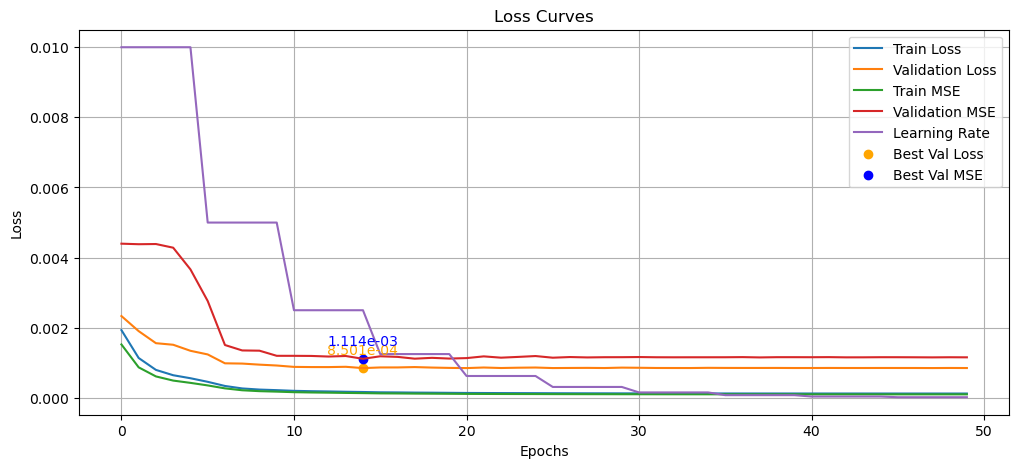

In [543]:
plot_loss_curves(train_loss_vec, val_loss_vec, train_mse_vec, val_mse_vec,  lr_vec)

C:\Users\cathalert\AppData\Local\Temp\ipykernel_37276\3559100692.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(folder, c

0005_epoch_checkpoint.pth


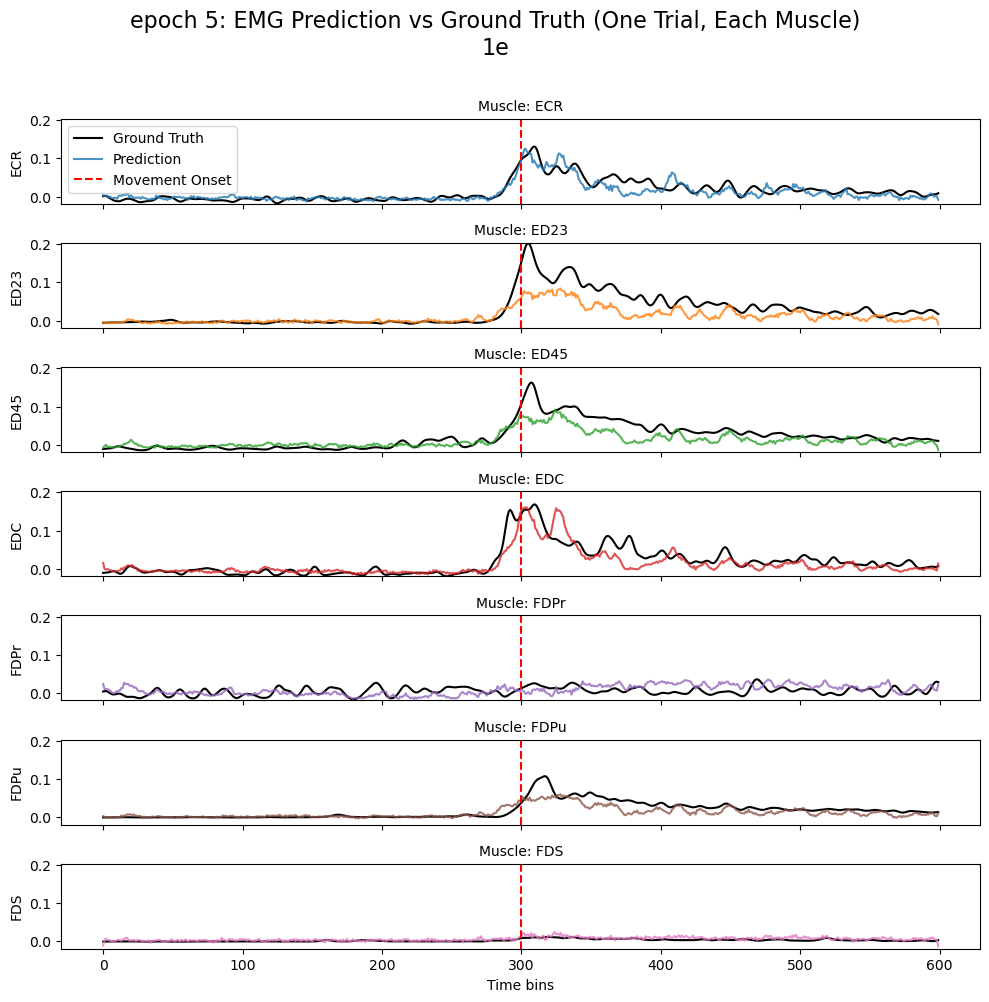

0010_epoch_checkpoint.pth


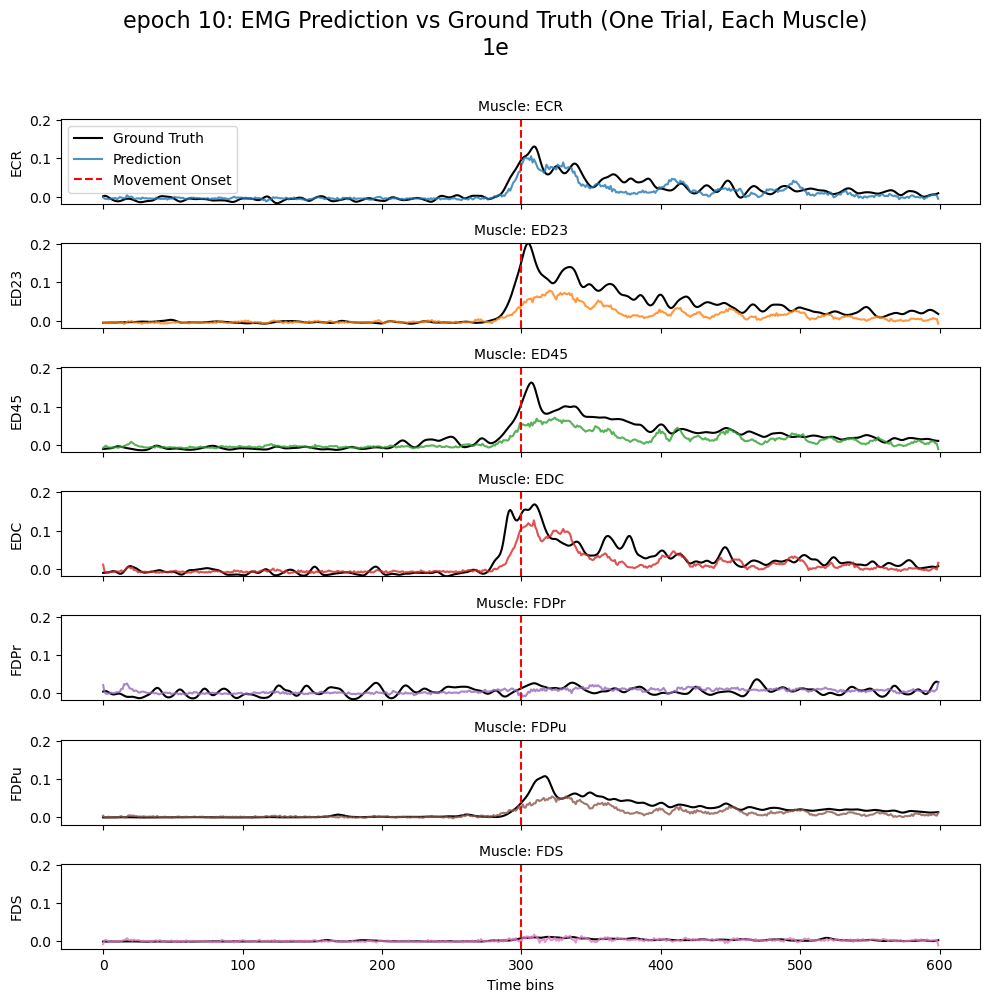

0015_epoch_checkpoint.pth


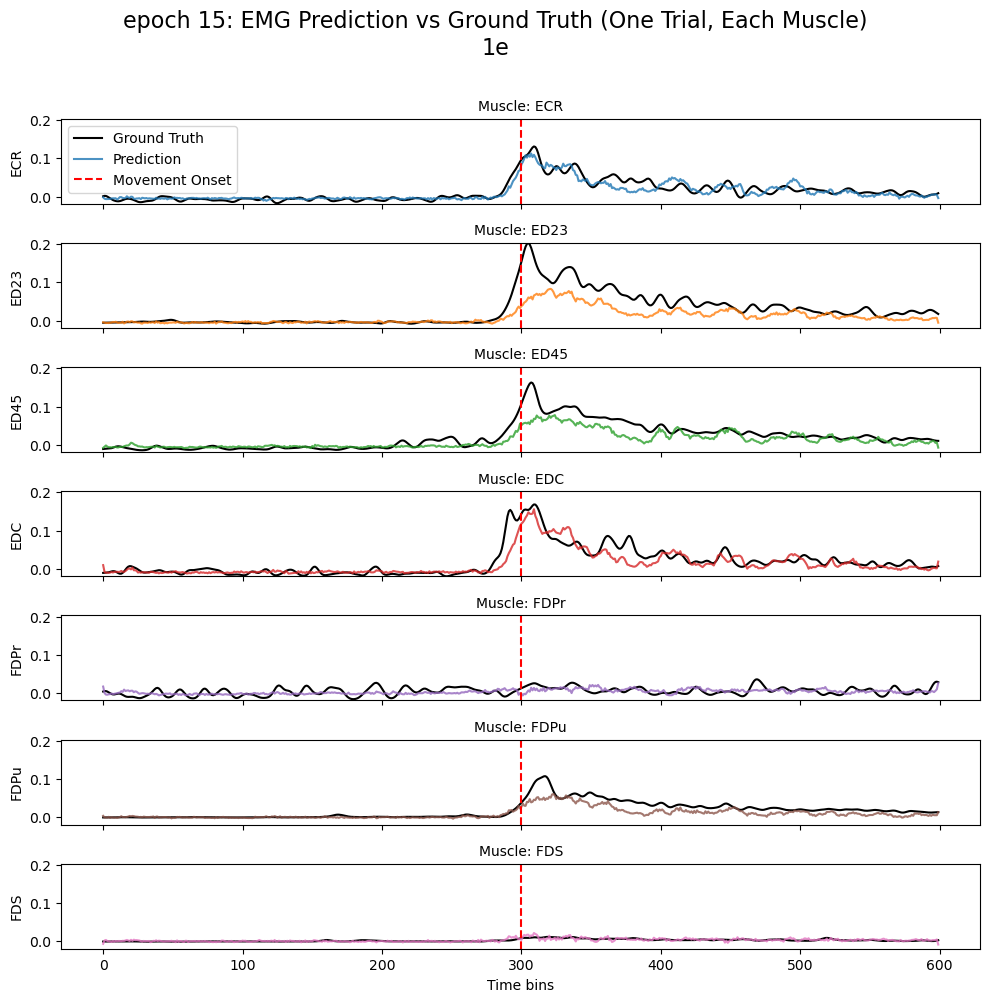

0020_epoch_checkpoint.pth


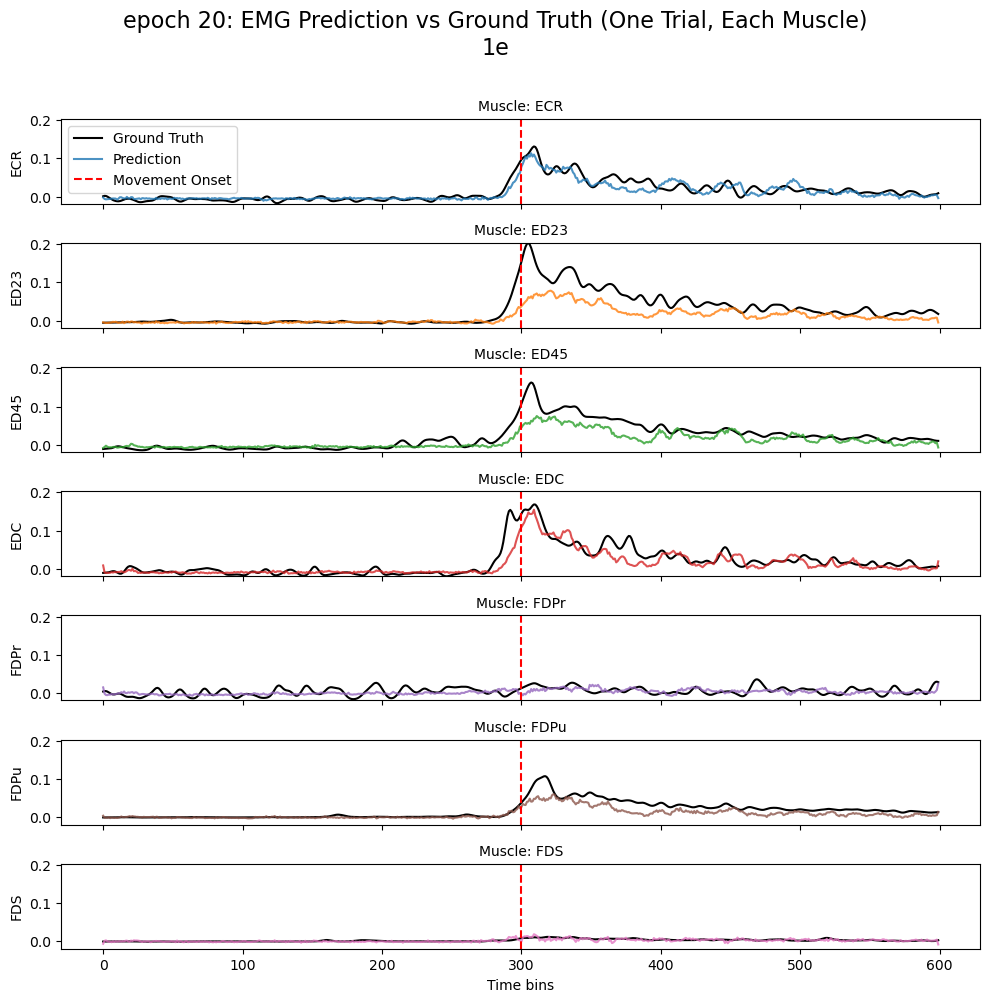

0025_epoch_checkpoint.pth


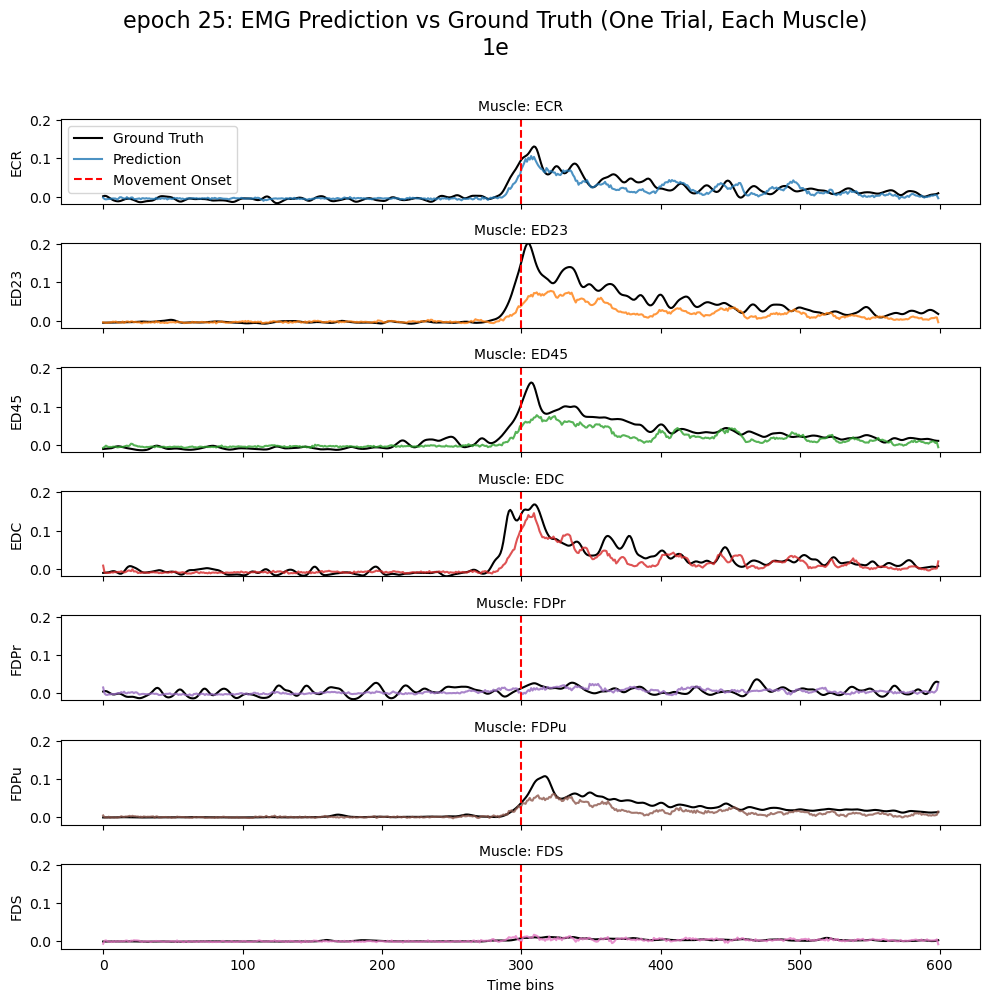

0030_epoch_checkpoint.pth


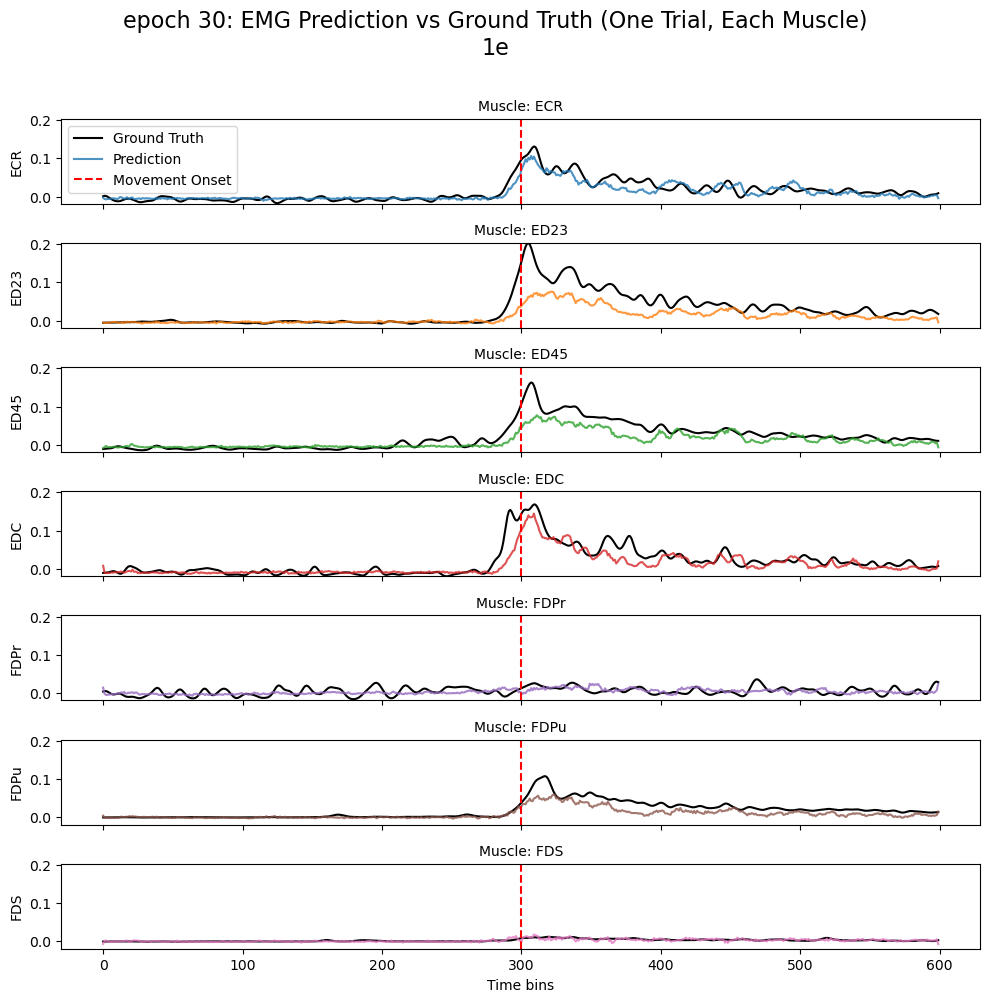

0035_epoch_checkpoint.pth


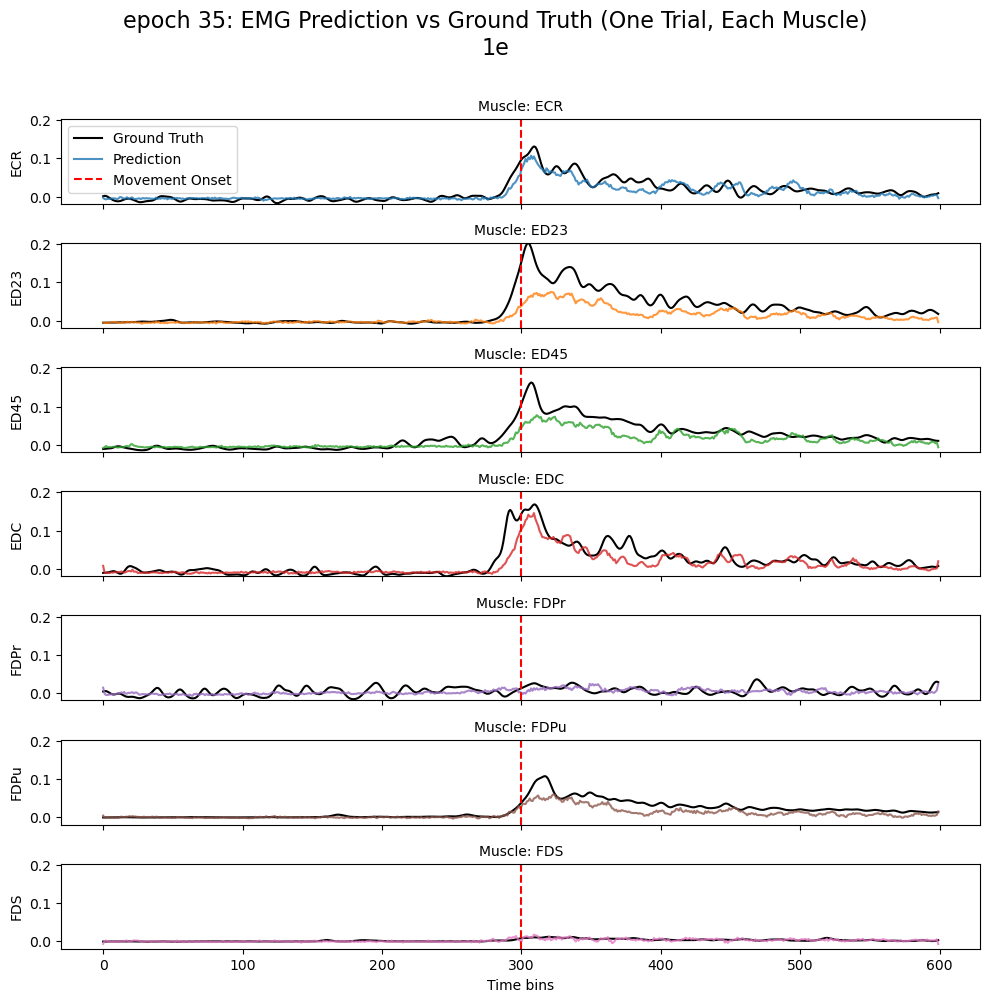

0040_epoch_checkpoint.pth


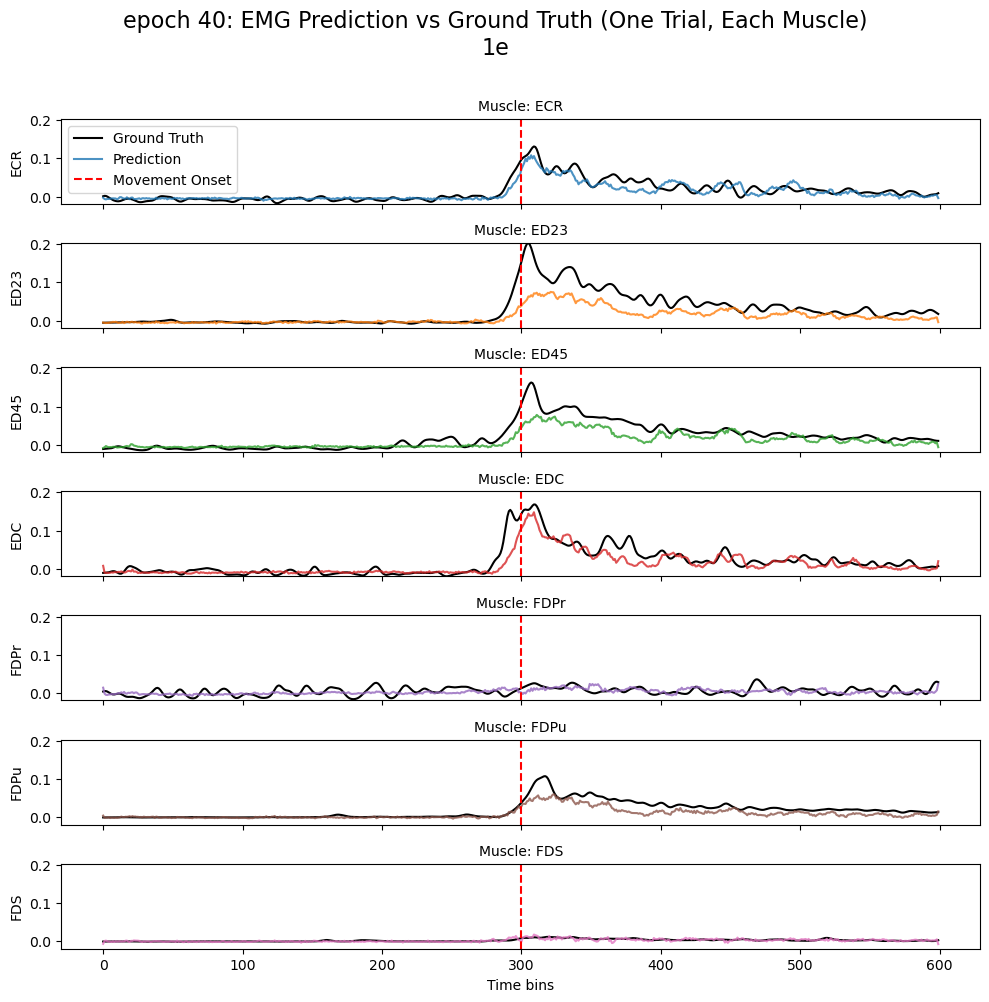

0045_epoch_checkpoint.pth


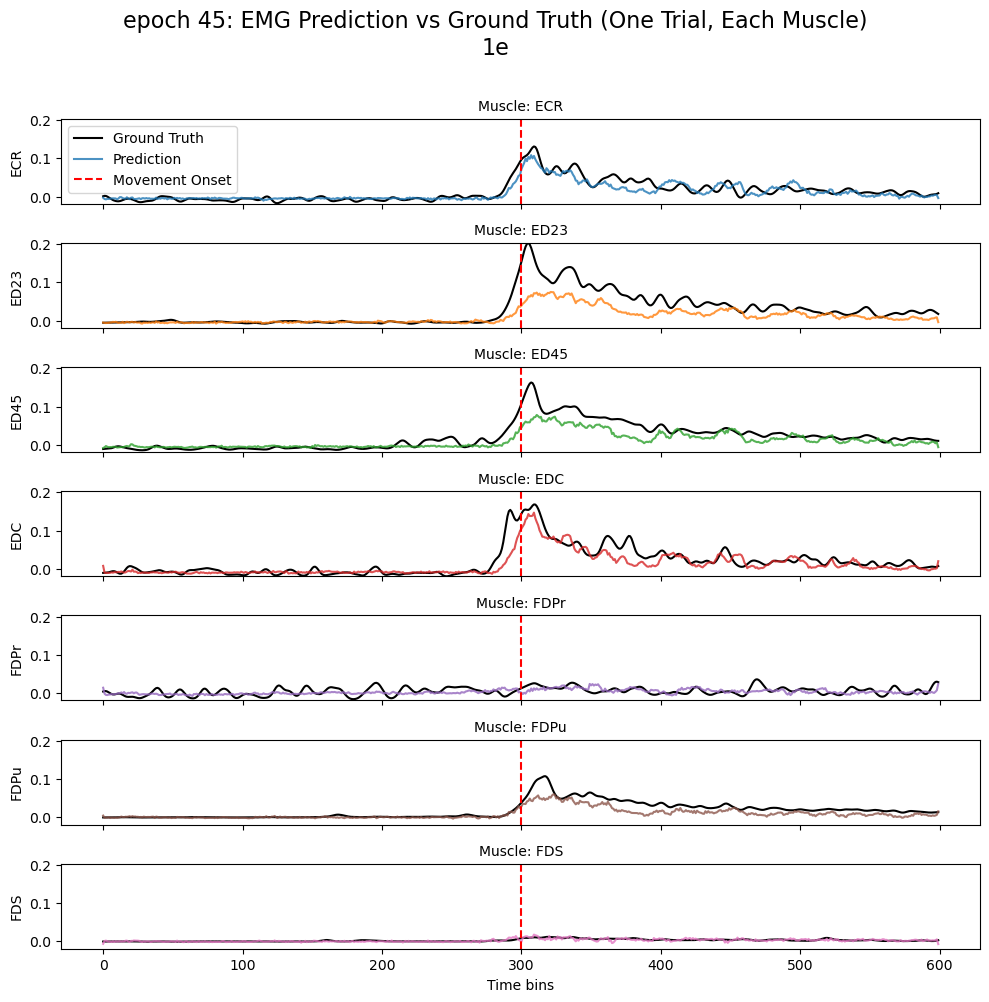

0050_epoch_checkpoint.pth


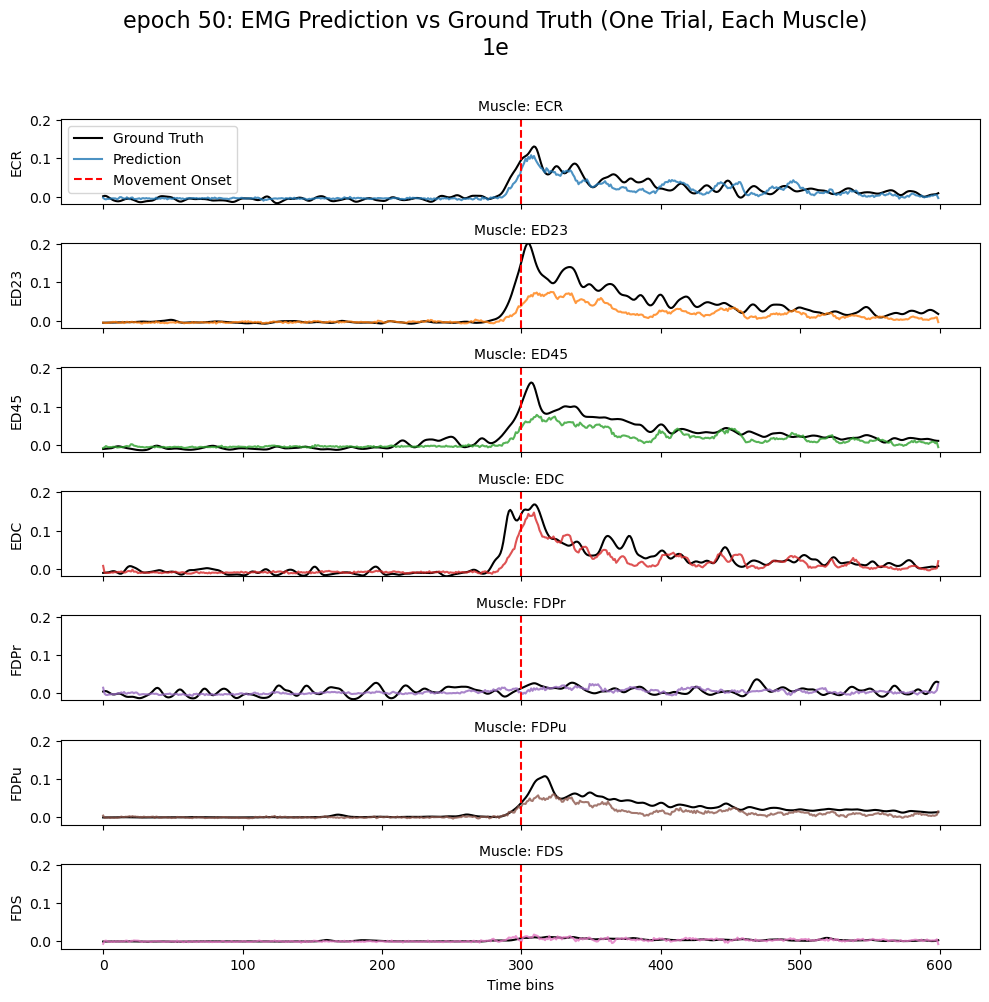

best_model.pth


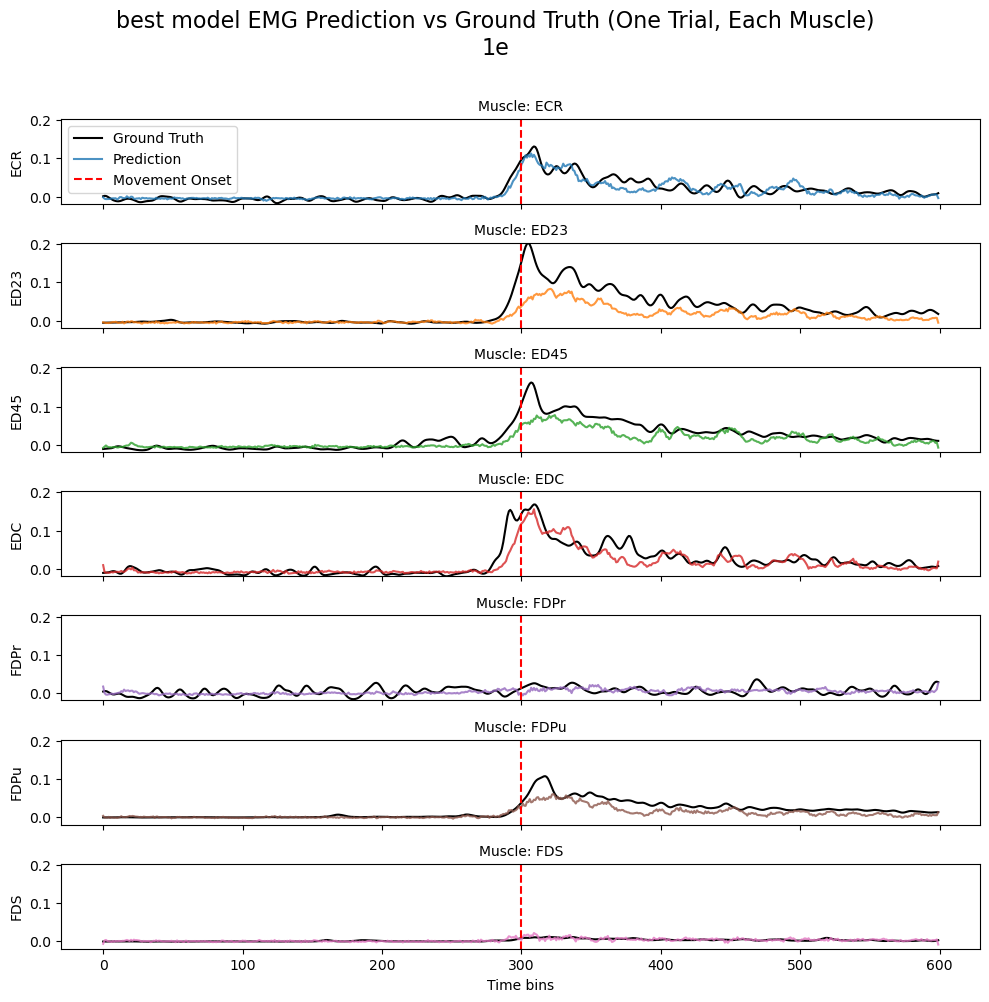

In [544]:
sample_index = 0
sample_movement = movement_names[sample_index // 50]
x_s = x_val[sample_index]
y_s = y_val[sample_index]
y_s = y_s.reshape(1, y_s.shape[0], y_s.shape[1])
x_s = torch.tensor(x_s, dtype=torch.float32).unsqueeze(0).to(device)
y_s = torch.tensor(y_s, dtype=torch.float32).to(device)
y_s = y_s.cpu().numpy()

folder = "model_2_big_checkpoints"
for chkp in os.listdir(folder):
    if chkp.endswith(".pth"):
        print(chkp)
        model.load_state_dict(torch.load(os.path.join(folder, chkp)))
        model.eval()
        with torch.no_grad():
            pred = model(x_s)
        pred = pred.cpu().numpy()
        
        # plot it!
        n_muscles = y_s.shape[1]
        n_time = y_s.shape[2]
        # Get global min/max for axis limits
        y_min = min(y_s[0].min(), pred[0].min())
        y_max = max(y_s[0].max(), pred[0].max())

        # Use a color palette for muscles
        colors = plt.cm.tab10.colors if n_muscles <= 10 else plt.cm.tab20.colors
        
        fig, axs = plt.subplots(n_muscles, 1, figsize=(10, 1.5 * n_muscles), sharex=True)
        if n_muscles == 1:
            axs = [axs]
        for j in range(n_muscles):
            axs[j].plot(y_s[0, j], label='Ground Truth', color='black', linewidth=1.5)
            axs[j].plot(pred[0, j], label='Prediction', color=colors[j % len(colors)], alpha=0.8, linewidth=1.5)
            axs[j].axvline(x=300, color='red', linestyle='--', label='Movement Onset' if j == 0 else None)
            axs[j].set_ylabel(muscle_idx_dict[j])
            axs[j].set_title(f"Muscle: {muscle_idx_dict[j]}", fontsize=10)
            axs[j].set_ylim(y_min, y_max)
            if j == 0:
                axs[j].legend()
        axs[-1].set_xlabel('Time bins')
        if chkp != "best_model.pth":
            plt.suptitle(f'epoch {str(int(chkp[:4]))}: EMG Prediction vs Ground Truth (One Trial, Each Muscle)\n{sample_movement}', fontsize=16)
        else:
            plt.suptitle(f'best model EMG Prediction vs Ground Truth (One Trial, Each Muscle)\n{sample_movement}', fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.97])
        plt.show()
        




# Digit Kinematics


In [545]:
class SpikeToEMGToFingers(nn.Module):
    def __init__(self, n_neurons, emg_channels, finger_channels, time_bins):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(n_neurons, 64, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(128, 128, kernel_size=3, padding=1),
            nn.ReLU()
        )

        self.emg_head = nn.Sequential(
            nn.Conv1d(128, emg_channels, kernel_size=1),
            nn.Upsample(size=time_bins, mode='linear', align_corners=True)
        )

        self.finger_head = nn.Sequential(
            nn.Conv1d(emg_channels, finger_channels, kernel_size=3, padding=1),
            nn.Upsample(size=time_bins, mode='linear', align_corners=True)
        )

    def forward(self, x):
        features = self.encoder(x)
        emg_pred = self.emg_head(features)
        finger_pred = self.finger_head(emg_pred)
        return emg_pred, finger_pred


def multitask_loss(emg_pred, emg_true, finger_pred, finger_true, alpha=1.0, beta=1.0):
    emg_loss = nn.functional.mse_loss(emg_pred, emg_true)
    finger_loss = nn.functional.mse_loss(finger_pred, finger_true)
    return alpha * emg_loss + beta * finger_loss


In [11]:

# === Load finger dicts ===
with open("dataset/Chip/train/y_fingers_dict.pkl", "rb") as f:
    y_f = pickle.load(f)
with open("dataset/Chip/validation/y_fingers_dict.pkl", "rb") as f:
    y_f_val = pickle.load(f)
with open("dataset/Chip/test/y_fingers_dict.pkl", "rb") as f:
    y_f_test = pickle.load(f)

# # === Extract muscle list and build aligned EMG arrays ===
digits = sorted({k for trial in y_f for k in trial})
n_muscles = len(digits)
finger_bins = 1250

delete_idx = []
for i in range(len(y_f)):
    if len(y_f[i]) != 6:
        delete_idx.append(i)
x , y, y_f = np.delete(x, delete_idx, axis=0), np.delete(y, delete_idx, axis=0), np.delete(y_f, delete_idx, axis=0)

delete_idx = []
for i in range(len(y_f_val)):
    if len(y_f_val[i]) != 6:
        delete_idx.append(i)
x_val , y_val, y_f_val = np.delete(x_val, delete_idx, axis=0), np.delete(y_val, delete_idx, axis=0), np.delete(y_f_val, delete_idx, axis=0)

delete_idx = []
for i in range(len(y_f_test)):
    if len(y_f_test[i]) != 6:
        delete_idx.append(i)
x_test , y_test, y_f_test = np.delete(x_test, delete_idx, axis=0), np.delete(y_test, delete_idx, axis=0), np.delete(y_f_test, delete_idx, axis=0)

# === Check if all trials have the same keys ===
for i in range(len(y_f)):
    if sorted(list(y_f[i].keys())) != digits:
        print(f"Trial {i} has different keys")  

y_f = emg_dicts_to_tensor(y_f, digits , finger_bins)[:, :, 200:800]
y_f_val = emg_dicts_to_tensor(y_f_val, digits , finger_bins)[:, :, 200:800]
y_f_test = emg_dicts_to_tensor(y_f_test, digits , finger_bins)[:, :, 200:800]

# === Check if all tensors have the same shape
print(f"X shape: {x.shape} y shape: {y.shape} y_f shape: {y_f.shape}")
print(f"X_val shape: {x_val.shape} y_val shape: {y_val.shape} y_f_val shape: {y_f_val.shape}")
print(f"X_test shape: {x_test.shape} y_test shape: {y_test.shape} y_f_test shape: {y_f_test.shape}")


# === Create Dataset for multitask learning ===
class SpikeToEMGToFingersDataset(Dataset):
    def __init__(self, X, Y_emg, Y_finger):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y_emg = torch.tensor(Y_emg, dtype=torch.float32)
        self.Y_finger = torch.tensor(Y_finger, dtype=torch.float32)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.Y_emg[idx], self.Y_finger[idx]
    
train_ds = SpikeToEMGToFingersDataset(x, y, y_f)
val_ds = SpikeToEMGToFingersDataset(x_val, y_val, y_f_val)
test_ds = SpikeToEMGToFingersDataset(x_test, y_test, y_f_test)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)
test_loader = DataLoader(test_ds, batch_size=32)


X shape: (600, 152, 600) y shape: (600, 7, 600) y_f shape: (600, 6, 600)
X_val shape: (330, 152, 600) y_val shape: (330, 7, 600) y_f_val shape: (330, 6, 600)
X_test shape: (416, 152, 600) y_test shape: (416, 7, 600) y_f_test shape: (416, 6, 600)


In [12]:
import torch
import torch.nn as nn

class SpikeConvToEMGAndFinger(nn.Module):
    def __init__(self, n_neurons, n_muscles, n_fingers, n_time_bins):
        super().__init__()
        
        # === Encoder: spikes → features ===
        self.encoder = nn.Sequential(
            nn.Conv1d(n_neurons, 64, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(128, 128, kernel_size=3, padding=1),
            nn.ReLU()
        )
        
        # === EMG decoder ===
        self.emg_decoder = nn.Sequential(
            nn.Conv1d(128, n_muscles, kernel_size=1),
            nn.Upsample(size=n_time_bins, mode='linear', align_corners=True)
        )
        
        # === Finger decoder: from predicted EMG ===
        self.finger_decoder = nn.Sequential(
            nn.Conv1d(n_muscles, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(64, n_fingers, kernel_size=1)
        )

    def forward(self, x):
        z = self.encoder(x)                   # [B, 128, T]
        emg_pred = self.emg_decoder(z)        # [B, n_muscles, T]
        finger_pred = self.finger_decoder(emg_pred)  # [B, n_fingers, T]
        return emg_pred, finger_pred


In [548]:
checkpoint_dir = "model_3_checkpoints"
checkpoint_interval = 25 # save every k epochs
n_epochs = 100
lr = 0.001
shcedual = True
step_size = 25
gamma = 0.5
os.makedirs(checkpoint_dir, exist_ok=True)

model = SpikeConvToEMGAndFinger(n_neurons=x.shape[1], n_muscles=y.shape[1], n_fingers=y_f.shape[1], n_time_bins=y.shape[2])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
if not shcedual:
    gamma = 1
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)


# === Metric Tracking ===
train_loss_vec = []
val_loss_vec = []
train_mse_vec = []
val_mse_vec = []
lr_vec = []
best_epoch = 0

# === Custom Weighted MSE Loss ===
def weighted_mse(pred, true):
    error = (pred - true) ** 2
    std = torch.std(true[:, :, 200:500], dim=2, keepdim=True)
    std = std / (torch.sum(std, dim=1, keepdim=True) + 1e-8)
    return torch.mean(error * (1 + std))


for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    total_mse_emg = 0
    total_mse_finger = 0

    for xb, y_emg, y_finger in train_loader:
        xb = xb.to(device)
        y_emg = y_emg.to(device)
        y_finger = y_finger.to(device)

        emg_pred, finger_pred = model(xb)

        loss_emg = weighted_mse(emg_pred, y_emg)
        loss_finger = weighted_mse(finger_pred, y_finger)
        loss = loss_emg + loss_finger

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_mse_emg += torch.mean((emg_pred - y_emg) ** 2).item()
        total_mse_finger += torch.mean((finger_pred - y_finger) ** 2).item()

    avg_train_loss = total_loss / len(train_loader)
    avg_train_mse_emg = total_mse_emg / len(train_loader)
    avg_train_mse_finger = total_mse_finger / len(train_loader)

    train_loss_vec.append(avg_train_loss)
    train_mse_vec.append((avg_train_mse_emg, avg_train_mse_finger))

    # === Validation ===
    model.eval()
    with torch.no_grad():
        val_total_loss = 0
        val_mse_emg = 0
        val_mse_finger = 0

        for xb_val, y_emg_val, y_finger_val in val_loader:
            xb_val = xb_val.to(device)
            y_emg_val = y_emg_val.to(device)
            y_finger_val = y_finger_val.to(device)

            emg_pred_val, finger_pred_val = model(xb_val)

            loss_emg_val = weighted_mse(emg_pred_val, y_emg_val)
            loss_finger_val = weighted_mse(finger_pred_val, y_finger_val)
            val_loss = loss_emg_val + loss_finger_val
            val_total_loss += val_loss.item()

            val_mse_emg += torch.mean((emg_pred_val - y_emg_val) ** 2).item()
            val_mse_finger += torch.mean((finger_pred_val - y_finger_val) ** 2).item()

        avg_val_loss = val_total_loss / len(val_loader)
        avg_val_mse_emg = val_mse_emg / len(val_loader)
        avg_val_mse_finger = val_mse_finger / len(val_loader)

        val_loss_vec.append(avg_val_loss)
        val_mse_vec.append((avg_val_mse_emg, avg_val_mse_finger))

    print(
        f"Epoch {epoch+1:02d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | "
        f"Train EMG MSE: {avg_train_mse_emg:.4f} | Finger MSE: {avg_train_mse_finger:.4f} | "
        f"Val EMG MSE: {avg_val_mse_emg:.4f} | Finger MSE: {avg_val_mse_finger:.4f} | "
        f"LR: {lr_scheduler.get_last_lr()[0]:.6f}"
    )
    lr_vec.append(lr_scheduler.get_last_lr()[0])
    lr_scheduler.step()

    # Save best model by total val MSE
    total_val_mse = avg_val_mse_emg + avg_val_mse_finger
    if len(val_mse_vec) == 1 or total_val_mse < sum(val_mse_vec[best_epoch - 1]):
        best_epoch = epoch + 1
        torch.save(model.state_dict(), os.path.join(checkpoint_dir, "best_model.pth"))

    # Checkpoint every k epochs
    if (epoch + 1) % checkpoint_interval == 0 or epoch == n_epochs - 1:
        ckpt_path = os.path.join(checkpoint_dir, f"{str(epoch+1).zfill(4)}_epoch_checkpoint.pth")
        torch.save(model.state_dict(), ckpt_path)
        print(f"✅ Saved checkpoint: {ckpt_path}")

print(f"Best epoch: {best_epoch}")
model.load_state_dict(torch.load(os.path.join(checkpoint_dir, "best_model.pth")))


Epoch 01 | Train Loss: 0.0345 | Val Loss: 0.0552 | Train EMG MSE: 0.0022 | Finger MSE: 0.0235 | Val EMG MSE: 0.0021 | Finger MSE: 0.0392 | LR: 0.001000
Epoch 02 | Train Loss: 0.0272 | Val Loss: 0.0506 | Train EMG MSE: 0.0011 | Finger MSE: 0.0185 | Val EMG MSE: 0.0016 | Finger MSE: 0.0359 | LR: 0.001000
Epoch 03 | Train Loss: 0.0258 | Val Loss: 0.0497 | Train EMG MSE: 0.0008 | Finger MSE: 0.0177 | Val EMG MSE: 0.0014 | Finger MSE: 0.0355 | LR: 0.001000
Epoch 04 | Train Loss: 0.0251 | Val Loss: 0.0492 | Train EMG MSE: 0.0008 | Finger MSE: 0.0172 | Val EMG MSE: 0.0016 | Finger MSE: 0.0351 | LR: 0.001000
Epoch 05 | Train Loss: 0.0239 | Val Loss: 0.0477 | Train EMG MSE: 0.0011 | Finger MSE: 0.0160 | Val EMG MSE: 0.0016 | Finger MSE: 0.0340 | LR: 0.001000
Epoch 06 | Train Loss: 0.0222 | Val Loss: 0.0461 | Train EMG MSE: 0.0012 | Finger MSE: 0.0148 | Val EMG MSE: 0.0015 | Finger MSE: 0.0331 | LR: 0.001000
Epoch 07 | Train Loss: 0.0204 | Val Loss: 0.0448 | Train EMG MSE: 0.0012 | Finger MSE: 0

C:\Users\cathalert\AppData\Local\Temp\ipykernel_37276\2609294333.py:119: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(checkpoi

<All keys matched successfully>

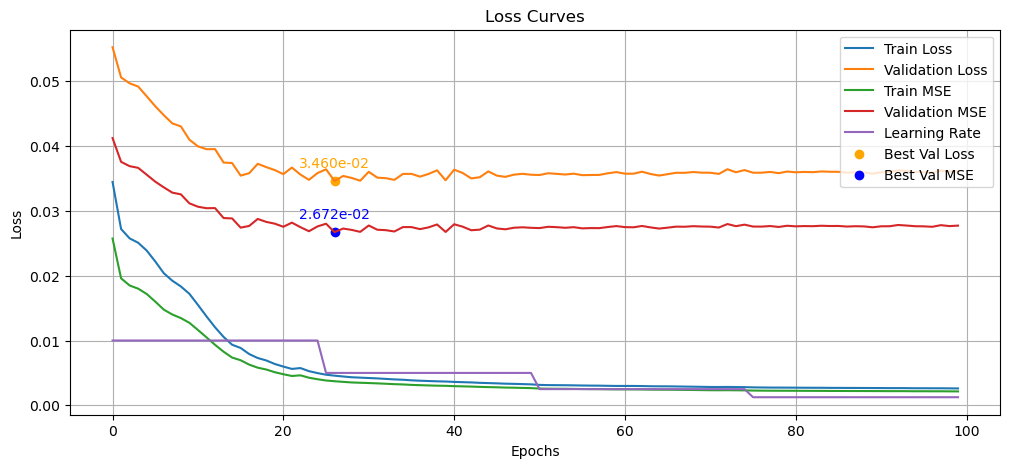

In [549]:
plot_loss_curves(train_loss_vec, val_loss_vec, [a+b for a,b in train_mse_vec],[a+b for a,b in  val_mse_vec],  lr_vec)

In [10]:
sample_index = 0
sample_movement = movement_names[sample_index // 50]
x_s = x_val[sample_index]
y_s = y_val[sample_index]
y_f_s = y_f_val[sample_index]
y_s = y_s.reshape(1, y_s.shape[0], y_s.shape[1])
y_f_s = y_f_s.reshape(1, y_f_s.shape[0], y_f_s.shape[1])

x_s = torch.tensor(x_s, dtype=torch.float32).unsqueeze(0).to(device)
y_s = torch.tensor(y_s, dtype=torch.float32).to(device)
y_f_s = torch.tensor(y_f_s, dtype=torch.float32).to(device)

y_s = y_s.cpu().numpy()
y_f_s = y_f_s.cpu().numpy()

folder = "model_3_checkpoints"
for chkp in os.listdir(folder):
    if chkp.endswith(".pth"):
        print(chkp)
        model.load_state_dict(torch.load(os.path.join(folder, chkp)))
        model.eval()
        with torch.no_grad():
            emg_pred, finger_pred = model(x_s)
        emg_pred = emg_pred.cpu().numpy()
        finger_pred = finger_pred.cpu().numpy()
        
        # plot it!
        n_muscles = y_s.shape[1]
        n_time = y_s.shape[2]

        n_fingers = y_f_s.shape[1]
        n_time_finger = y_f_s.shape[2]

        # Get global min/max for axis limits
        y_min = min(y_s[0].min(), emg_pred[0].min())
        y_max = max(y_s[0].max(), emg_pred[0].max())
        y_f_min = min(y_f_s[0].min(), finger_pred[0].min())
        y_f_max = max(y_f_s[0].max(), finger_pred[0].max())
        
        # Use a color palette for muscles
        colors = plt.cm.tab10.colors if n_muscles <= 10 else plt.cm.tab20.colors
        
        fig, axs = plt.subplots(max(n_muscles, n_fingers), 2, figsize=(14, 2.2 * max(n_muscles, n_fingers)), sharex='col')
        # EMG plots (left column)
        for j in range(n_muscles):
            ax = axs[j, 0] if n_muscles > 1 else axs[0, 0]
            ax.plot(y_s[0, j], label='Ground Truth', color='black', linewidth=1.5)
            ax.plot(emg_pred[0, j], label='Prediction', color=colors[j % len(colors)], alpha=0.8, linewidth=1.5)
            ax.axvline(x=300, color='red', linestyle='--', label='Movement Onset' if j == 0 else None)
            ax.set_ylabel(muscle_idx_dict[j])
            ax.set_title(f"EMG: {muscle_idx_dict[j]}", fontsize=10)
            ax.set_ylim(y_min, y_max)
            if j == 0:
                ax.legend()
        axs[max(n_muscles, n_fingers)-1, 0].set_xlabel('Time bins')
        # Finger/digit plots (right column)
        for j in range(n_fingers):
            ax = axs[j, 1] if n_fingers > 1 else axs[0, 1]
            ax.plot(y_f_s[0, j], label='Ground Truth', color='black', linewidth=1.5)
            ax.plot(finger_pred[0, j], label='Prediction', color=colors[j % len(colors)], alpha=0.8, linewidth=1.5)
            ax.axvline(x=300, color='red', linestyle='--', label='Movement Onset' if j == 0 else None)
            ax.set_ylabel(f"Digit {j+1}")
            ax.set_title(f"Digit: {j+1}", fontsize=10)
            ax.set_ylim(y_f_min, y_f_max)
            if j == 0:
                ax.legend()
        axs[max(n_muscles, n_fingers)-1, 1].set_xlabel('Time bins')
        if chkp != "best_model.pth":
            plt.suptitle(f'epoch {str(int(chkp[:4]))}: EMG Prediction vs Ground Truth (One Trial, Each Muscle)\n{sample_movement}', fontsize=16)
        else:
            plt.suptitle(f'best model EMG Prediction vs Ground Truth (One Trial, Each Muscle)\n{sample_movement}', fontsize=16)

        plt.tight_layout(rect=[0, 0.03, 1, 0.97])
        plt.show()
        




NameError: name 'y_f_val' is not defined

In [ ]:
def train_model_with_phases(model, train_loader, val_loader, n_epochs=100, lr=0.001,
                             checkpoint_dir="model_3_checkpoints", checkpoint_interval=25,
                             schedule=True, step_size=25, gamma=0.5, device='cuda'):
    import os
    import torch
    import torch.nn.functional as F

    os.makedirs(checkpoint_dir, exist_ok=True)

    phase1_end = n_epochs // 3
    phase2_end = 2 * n_epochs // 3

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    if schedule:
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    else:
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=1.0)

    train_loss_vec, val_loss_vec = [], []
    train_mse_vec, val_mse_vec = [], []
    lr_vec = []
    best_epoch = 0

    def weighted_mse(pred, true):
        error = (pred - true) ** 2
        std = torch.std(true[:, :, 200:500], dim=2, keepdim=True)
        std = std / (torch.sum(std, dim=1, keepdim=True) + 1e-8)
        return torch.mean(error * (1 + std))

    for epoch in range(n_epochs):
        # === Phase Transitions ===
        if epoch == phase1_end:
            for param in model.encoder.parameters():
                param.requires_grad = False
            for param in model.emg_decoder.parameters():
                param.requires_grad = False
            optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
            if schedule:
                lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

        elif epoch == phase2_end:
            for param in model.parameters():
                param.requires_grad = True
            optimizer = torch.optim.Adam(model.parameters(), lr=lr * 0.1)
            if schedule:
                lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

        # === Training ===
        model.train()
        total_loss, total_mse_emg, total_mse_finger = 0, 0, 0
        for xb, y_emg, y_finger in train_loader:
            xb, y_emg, y_finger = xb.to(device), y_emg.to(device), y_finger.to(device)
            emg_pred, finger_pred = model(xb)

            loss_emg = weighted_mse(emg_pred, y_emg)
            loss_finger = weighted_mse(finger_pred, y_finger)
            loss = loss_emg if epoch < phase1_end else loss_emg + loss_finger

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_mse_emg += F.mse_loss(emg_pred, y_emg).item()
            total_mse_finger += F.mse_loss(finger_pred, y_finger).item()

        avg_train_loss = total_loss / len(train_loader)
        avg_train_mse_emg = total_mse_emg / len(train_loader)
        avg_train_mse_finger = total_mse_finger / len(train_loader)

        train_loss_vec.append(avg_train_loss)
        train_mse_vec.append((avg_train_mse_emg, avg_train_mse_finger))

        # === Validation ===
        model.eval()
        with torch.no_grad():
            val_total_loss, val_mse_emg, val_mse_finger = 0, 0, 0
            for xb_val, y_emg_val, y_finger_val in val_loader:
                xb_val, y_emg_val, y_finger_val = xb_val.to(device), y_emg_val.to(device), y_finger_val.to(device)
                emg_pred_val, finger_pred_val = model(xb_val)

                loss_emg_val = weighted_mse(emg_pred_val, y_emg_val)
                loss_finger_val = weighted_mse(finger_pred_val, y_finger_val)
                val_loss = loss_emg_val if epoch < phase1_end else loss_emg_val + loss_finger_val

                val_total_loss += val_loss.item()
                val_mse_emg += F.mse_loss(emg_pred_val, y_emg_val).item()
                val_mse_finger += F.mse_loss(finger_pred_val, y_finger_val).item()

            avg_val_loss = val_total_loss / len(val_loader)
            avg_val_mse_emg = val_mse_emg / len(val_loader)
            avg_val_mse_finger = val_mse_finger / len(val_loader)

            val_loss_vec.append(avg_val_loss)
            val_mse_vec.append((avg_val_mse_emg, avg_val_mse_finger))

        # === Log ===
        print(
            f"Epoch {epoch+1:03d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | "
            f"Train EMG MSE: {avg_train_mse_emg:.4f} | Finger MSE: {avg_train_mse_finger:.4f} | "
            f"Val EMG MSE: {avg_val_mse_emg:.4f} | Finger MSE: {avg_val_mse_finger:.4f} | "
            f"LR: {lr_scheduler.get_last_lr()[0]:.6f}"
        )
        lr_vec.append(lr_scheduler.get_last_lr()[0])
        lr_scheduler.step()

        # === Save Best Model ===
        total_val_mse = avg_val_mse_emg + avg_val_mse_finger
        if len(val_mse_vec) == 1 or total_val_mse < sum(val_mse_vec[best_epoch - 1]):
            best_epoch = epoch + 1
            torch.save(model.state_dict(), os.path.join(checkpoint_dir, "best_model.pth"))

        if (epoch + 1) % checkpoint_interval == 0 or epoch == n_epochs - 1:
            ckpt_path = os.path.join(checkpoint_dir, f"{str(epoch+1).zfill(4)}_epoch_checkpoint.pth")
            torch.save(model.state_dict(), ckpt_path)
            print(f"✅ Saved checkpoint: {ckpt_path}")

    print(f"🏁 Best epoch: {best_epoch}")
    model.load_state_dict(torch.load(os.path.join(checkpoint_dir, "best_model.pth")))

    return train_loss_vec, val_loss_vec, train_mse_vec, val_mse_vec, lr_vec, phase1_end, phase2_end

def plot_loss_curves_with_phases(train_loss_vec, val_loss_vec, train_mse_vec, val_mse_vec, lr_vec,
                                  phase1_end, phase2_end):
    import matplotlib.pyplot as plt
    import numpy as np

    epochs = np.arange(len(train_loss_vec))
    train_emg_mse = [x[0] for x in train_mse_vec]
    train_finger_mse = [x[1] for x in train_mse_vec]
    val_emg_mse = [x[0] for x in val_mse_vec]
    val_finger_mse = [x[1] for x in val_mse_vec]

    plt.figure(figsize=(14, 6))
    plt.plot(train_loss_vec, label="Train Loss", linewidth=2)
    plt.plot(val_loss_vec, label="Val Loss", linewidth=2)
    plt.plot(train_emg_mse, label="Train EMG MSE")
    plt.plot(train_finger_mse, label="Train Finger MSE")
    plt.plot(val_emg_mse, label="Val EMG MSE")
    plt.plot(val_finger_mse, label="Val Finger MSE")
    plt.plot([lr * 10 for lr in lr_vec], label="LR (×10)", linestyle='--')

    # Highlight phase changes
    for phase, label in zip([phase1_end, phase2_end], ["← Phase 2", "← Phase 3"]):
        plt.axvline(x=phase, color='gray', linestyle=':', linewidth=1.5)
        plt.text(phase + 0.5, plt.ylim()[1]*0.9, label, color='gray', fontsize=10, rotation=0)

    # Best validation loss
    best_val_loss_epoch = np.argmin(val_loss_vec)
    plt.scatter(best_val_loss_epoch, val_loss_vec[best_val_loss_epoch], color='orange', label='Best Val Loss')
    plt.annotate(f'{val_loss_vec[best_val_loss_epoch]:.3e}', (best_val_loss_epoch, val_loss_vec[best_val_loss_epoch]),
                 textcoords="offset points", xytext=(0,10), ha='center', color='orange')
    # add floating text in middle upper part of each phase - emg only, finger only , both
    plt.text(phase1_end/2, -0.0015, "EMG Only", fontsize=10, color='gray', ha='center')
    plt.text((phase1_end + phase2_end)/2, - 0.0015, "Fingers Only", fontsize=10, color='gray', ha='center')
    plt.text((phase2_end + len(train_loss_vec))/2, -0.0015, "Both", fontsize=10, color='gray', ha='center')
    
    plt.title("Training Progress with Phase Transitions")
    plt.xlabel("Epoch")
    plt.ylabel("Loss / MSE")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [15]:
model = SpikeConvToEMGAndFinger(
    n_neurons=x.shape[1],
    n_muscles=y.shape[1],
    n_fingers=y_f.shape[1],
    n_time_bins=y.shape[2]
).to(device)

train_loss_vec, val_loss_vec, train_mse_vec, val_mse_vec, lr_vec, phase1_end, phase2_end = train_model_with_phases(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    n_epochs=150,
    lr=0.001,
    checkpoint_dir="model_3_multiphase_checkpoints",
    checkpoint_interval=49,
    schedule=True,
    step_size=25,
    gamma=0.5,
    device=device
)

plot_loss_curves_with_phases(
    train_loss_vec, val_loss_vec,
    train_mse_vec, val_mse_vec,
    lr_vec, phase1_end, phase2_end
)



NameError: name 'train_model_with_phases' is not defined

0049_epoch_checkpoint.pth


C:\Users\cathalert\AppData\Local\Temp\ipykernel_4388\1377367244.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(folder, ch

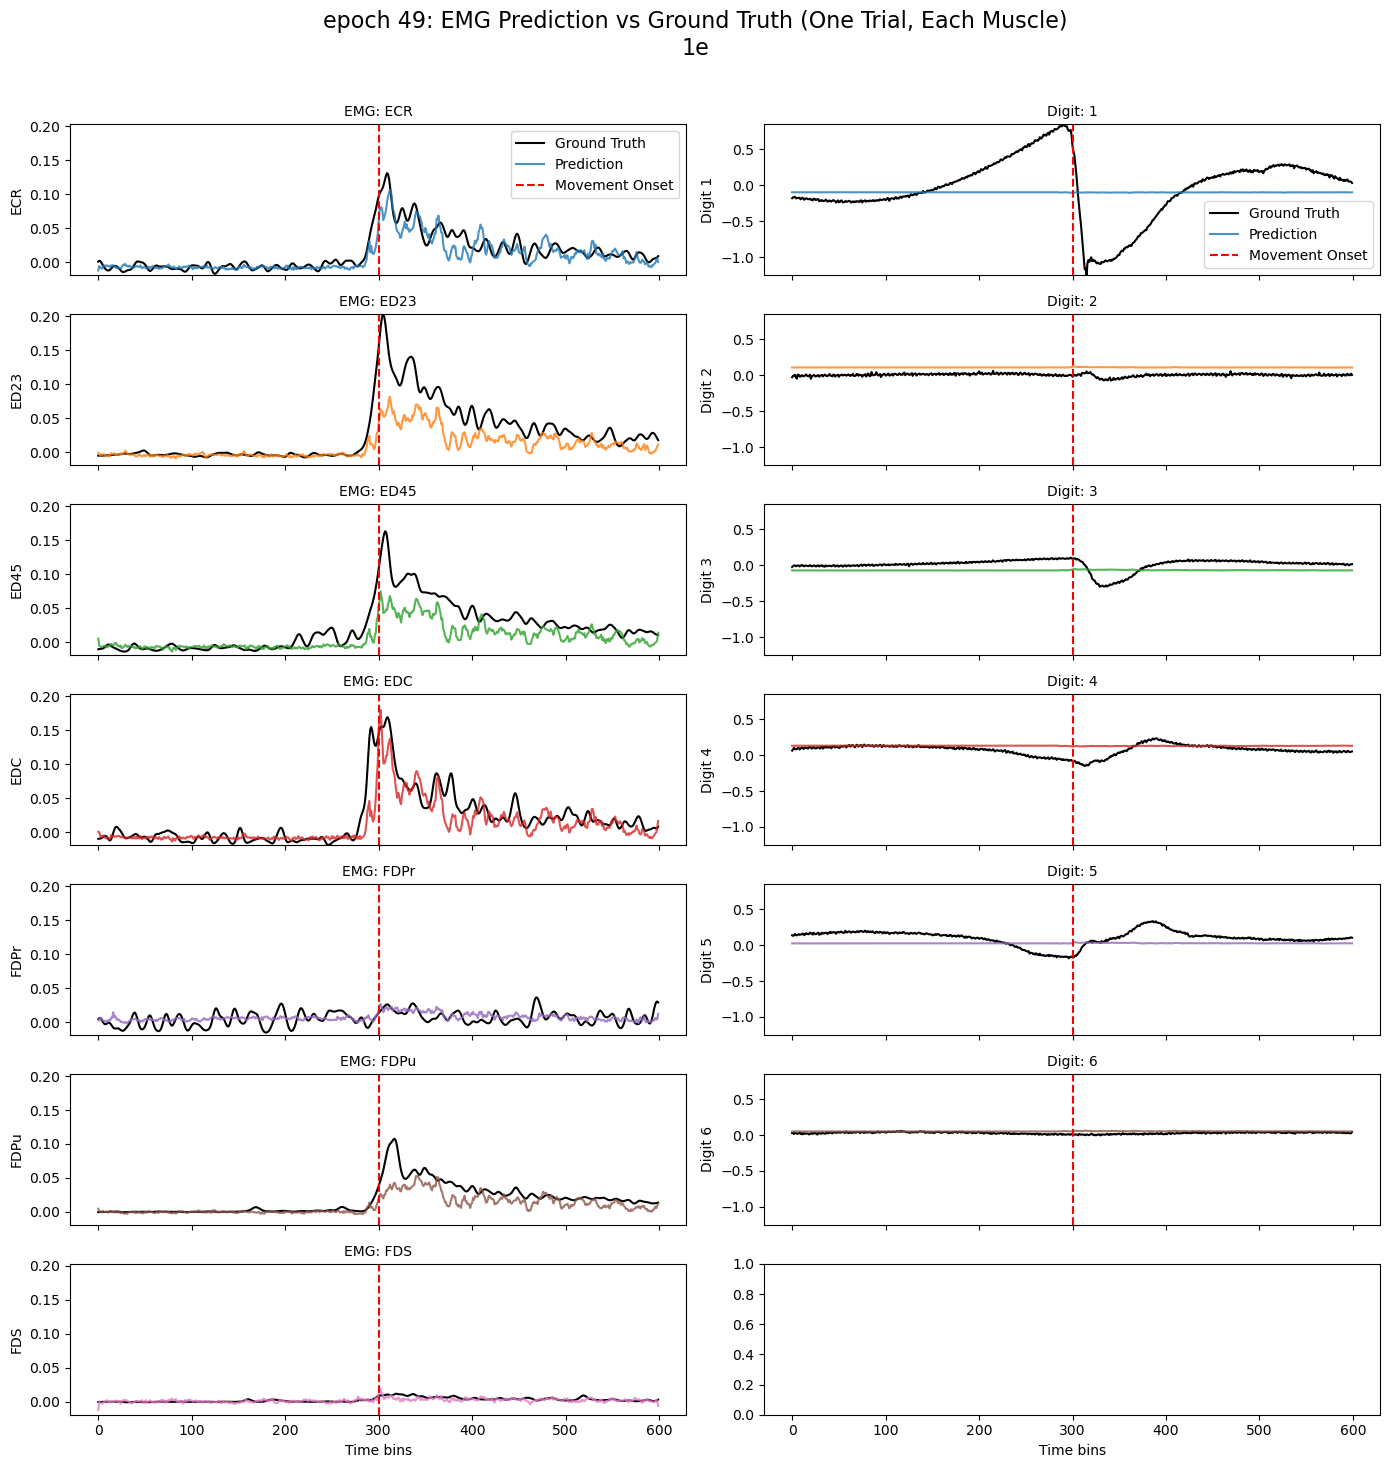

0098_epoch_checkpoint.pth


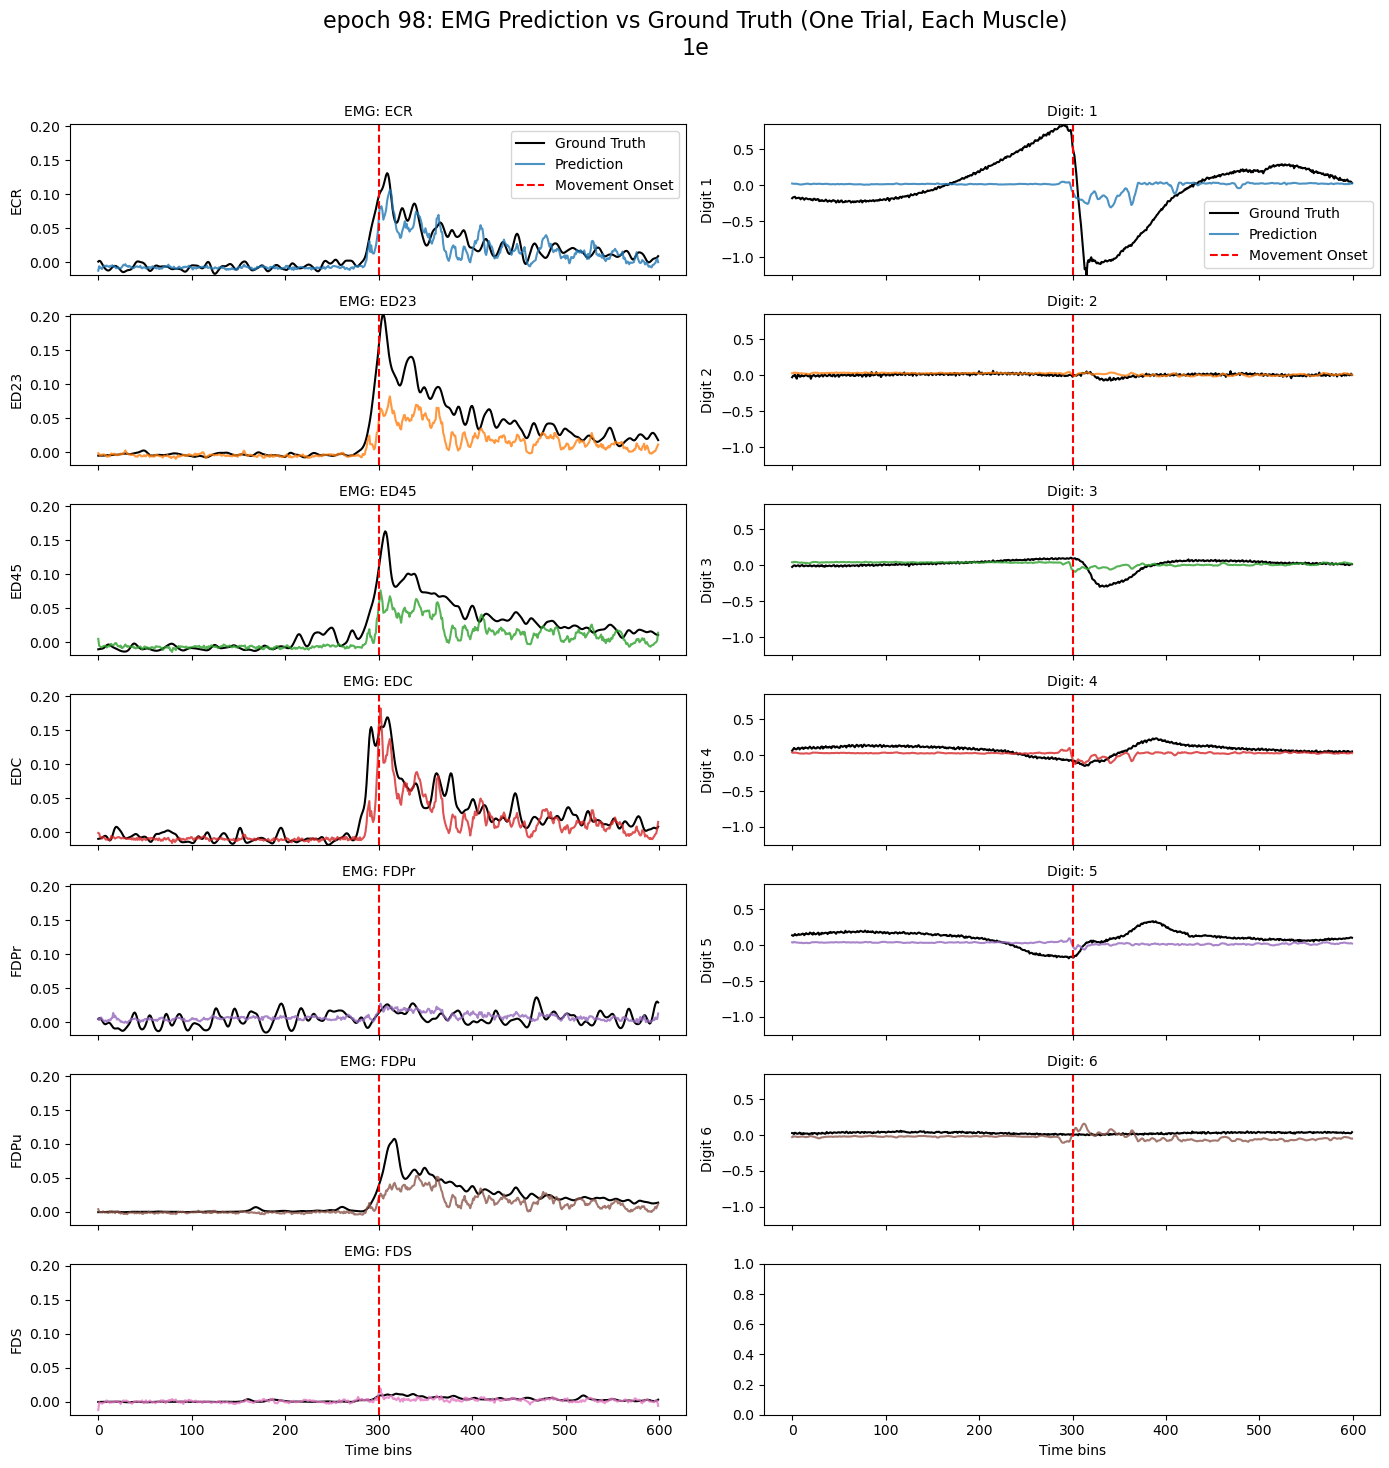

0147_epoch_checkpoint.pth


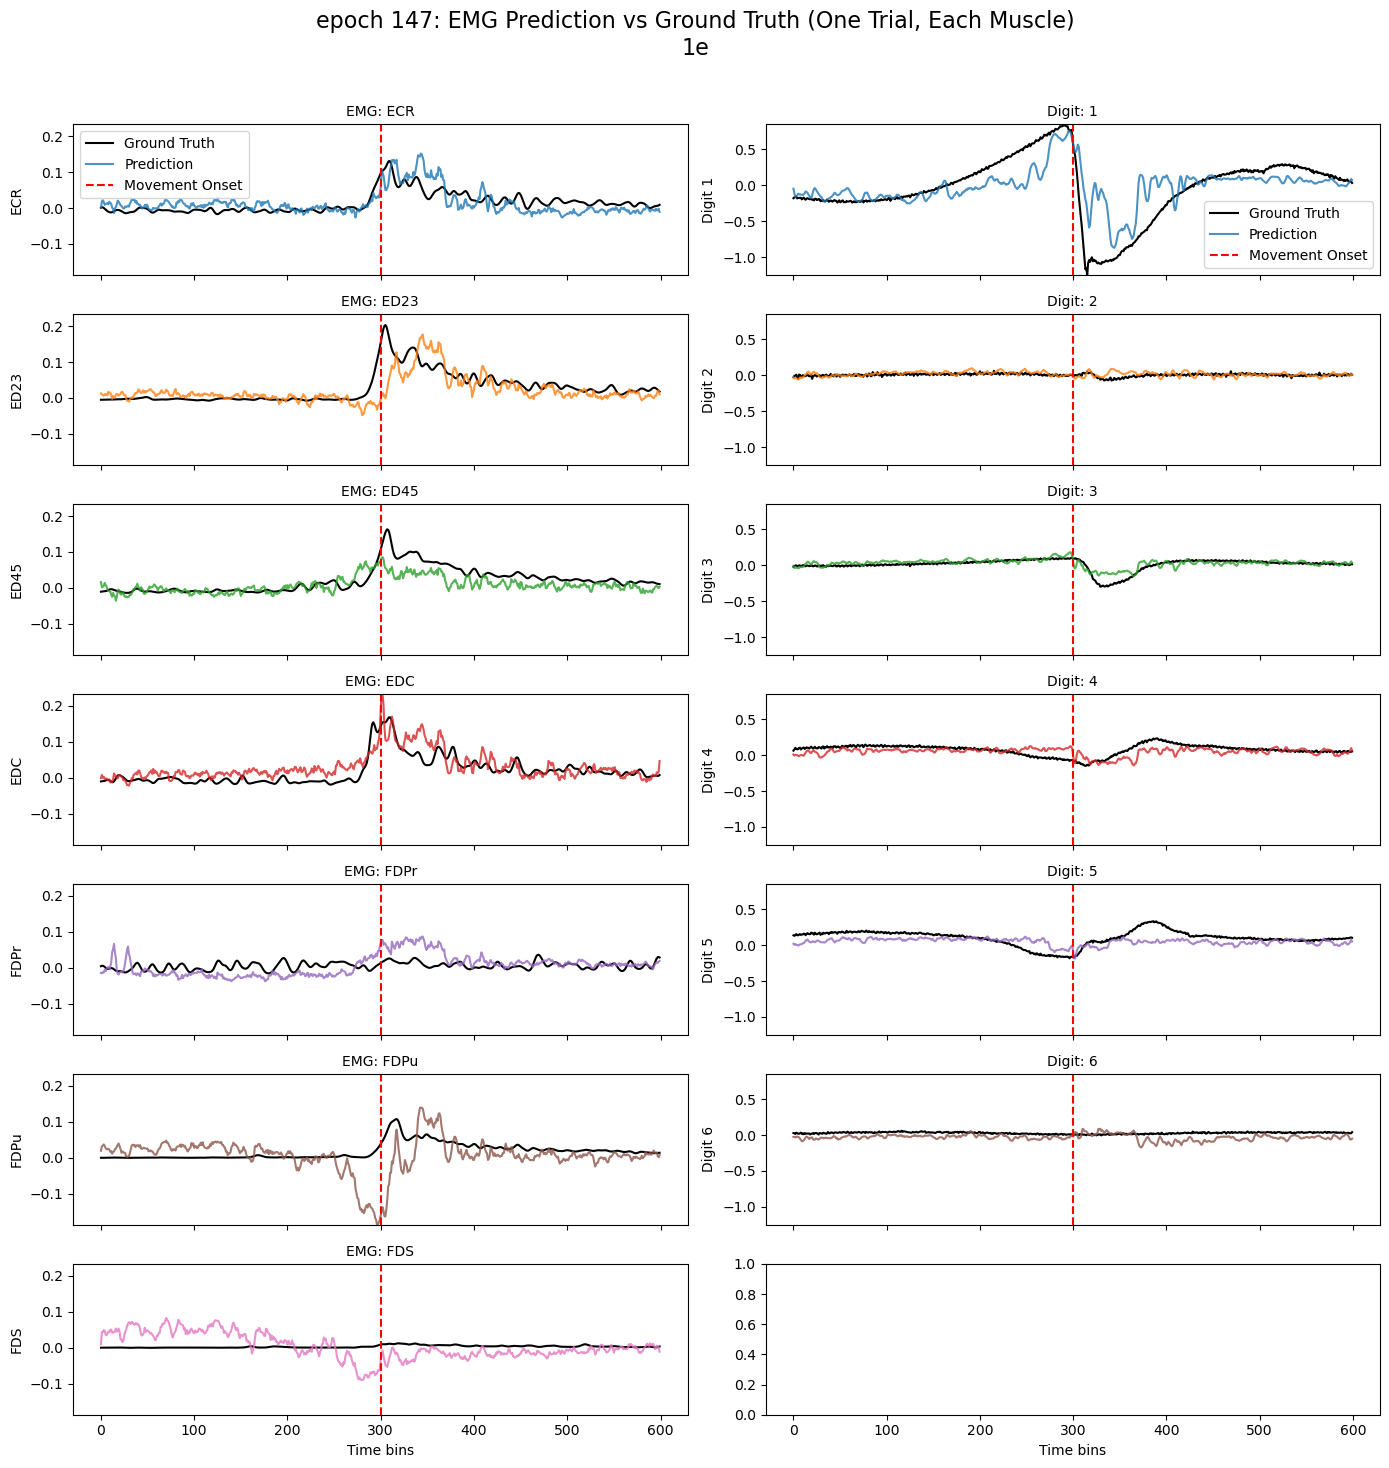

0150_epoch_checkpoint.pth


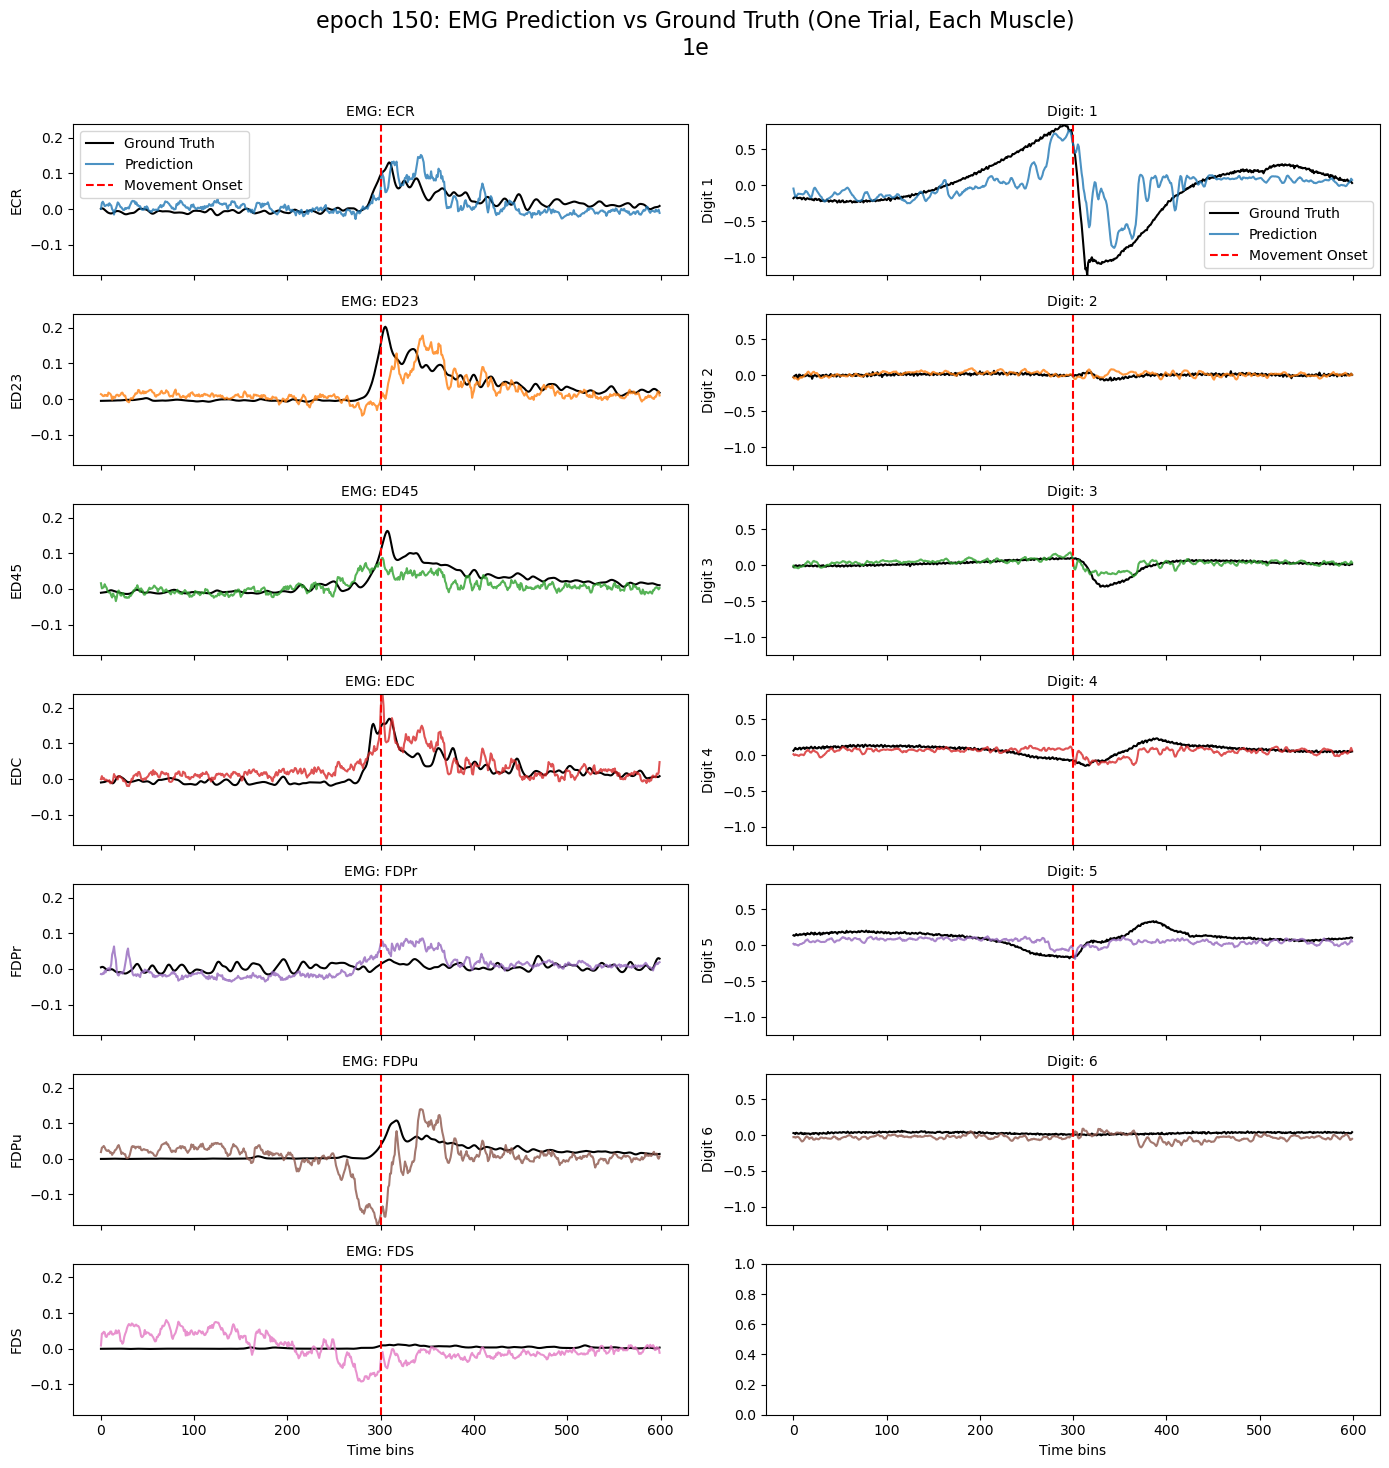

best_model.pth


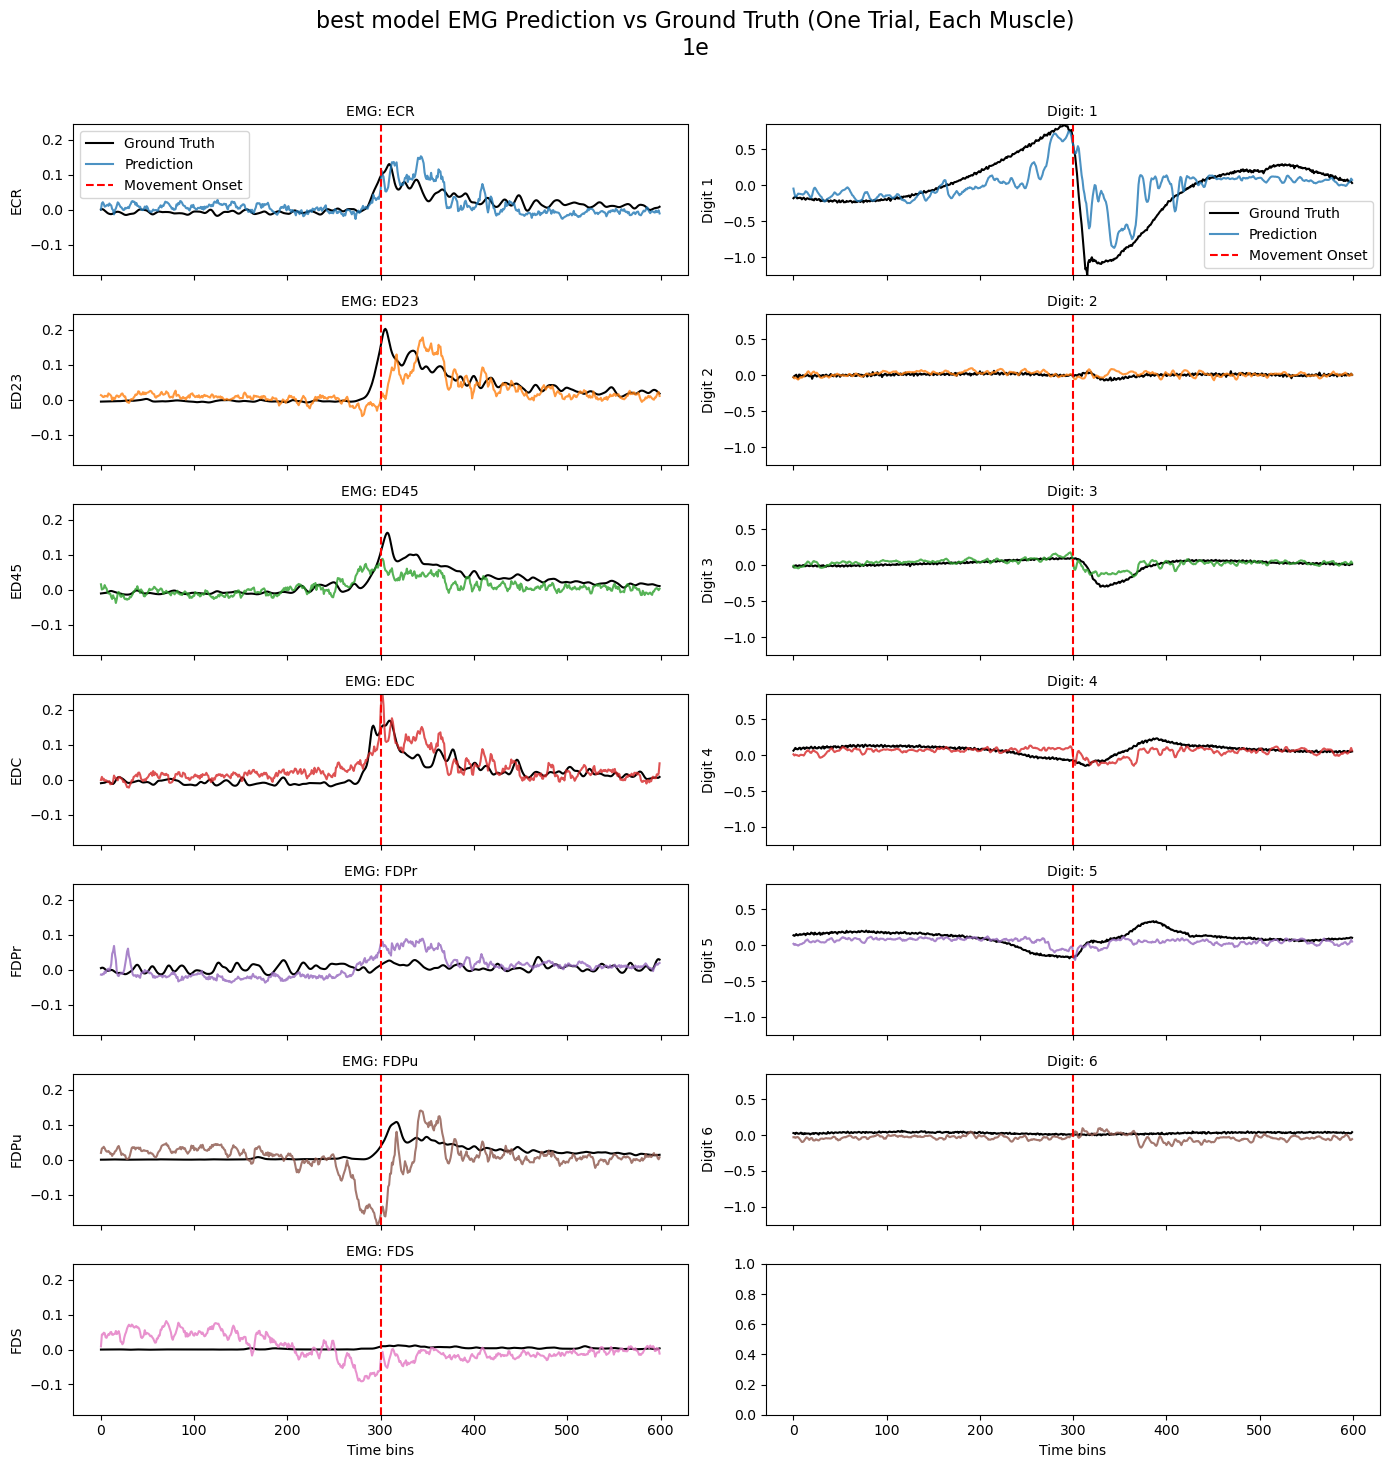

In [16]:
sample_index = 0
sample_movement = movement_names[sample_index // 50]
x_s = x_val[sample_index]
y_s = y_val[sample_index]
y_f_s = y_f_val[sample_index]
y_s = y_s.reshape(1, y_s.shape[0], y_s.shape[1])
y_f_s = y_f_s.reshape(1, y_f_s.shape[0], y_f_s.shape[1])

x_s = torch.tensor(x_s, dtype=torch.float32).unsqueeze(0).to(device)
y_s = torch.tensor(y_s, dtype=torch.float32).to(device)
y_f_s = torch.tensor(y_f_s, dtype=torch.float32).to(device)

y_s = y_s.cpu().numpy()
y_f_s = y_f_s.cpu().numpy()


model = SpikeConvToEMGAndFinger(
    n_neurons=x.shape[1],
    n_muscles=y.shape[1],
    n_fingers=y_f.shape[1],
    n_time_bins=y.shape[2]
).to(device)
folder = "model_3_multiphase_checkpoints"
for chkp in os.listdir(folder):
    if chkp.endswith(".pth"):
        print(chkp)
        model.load_state_dict(torch.load(os.path.join(folder, chkp)))
        model.eval()
        with torch.no_grad():
            emg_pred, finger_pred = model(x_s)
        emg_pred = emg_pred.cpu().numpy()
        finger_pred = finger_pred.cpu().numpy()
        
        # plot it!
        n_muscles = y_s.shape[1]
        n_time = y_s.shape[2]

        n_fingers = y_f_s.shape[1]
        n_time_finger = y_f_s.shape[2]

        # Get global min/max for axis limits
        y_min = min(y_s[0].min(), emg_pred[0].min())
        y_max = max(y_s[0].max(), emg_pred[0].max())
        y_f_min = min(y_f_s[0].min(), finger_pred[0].min())
        y_f_max = max(y_f_s[0].max(), finger_pred[0].max())
        
        # Use a color palette for muscles
        colors = plt.cm.tab10.colors if n_muscles <= 10 else plt.cm.tab20.colors
        
        fig, axs = plt.subplots(max(n_muscles, n_fingers), 2, figsize=(14, 2.2 * max(n_muscles, n_fingers)), sharex='col')
        # EMG plots (left column)
        for j in range(n_muscles):
            ax = axs[j, 0] if n_muscles > 1 else axs[0, 0]
            ax.plot(y_s[0, j], label='Ground Truth', color='black', linewidth=1.5)
            ax.plot(emg_pred[0, j], label='Prediction', color=colors[j % len(colors)], alpha=0.8, linewidth=1.5)
            ax.axvline(x=300, color='red', linestyle='--', label='Movement Onset' if j == 0 else None)
            ax.set_ylabel(muscle_idx_dict[j])
            ax.set_title(f"EMG: {muscle_idx_dict[j]}", fontsize=10)
            ax.set_ylim(y_min, y_max)
            if j == 0:
                ax.legend()
        axs[max(n_muscles, n_fingers)-1, 0].set_xlabel('Time bins')
        # Finger/digit plots (right column)
        for j in range(n_fingers):
            ax = axs[j, 1] if n_fingers > 1 else axs[0, 1]
            ax.plot(y_f_s[0, j], label='Ground Truth', color='black', linewidth=1.5)
            ax.plot(finger_pred[0, j], label='Prediction', color=colors[j % len(colors)], alpha=0.8, linewidth=1.5)
            ax.axvline(x=300, color='red', linestyle='--', label='Movement Onset' if j == 0 else None)
            ax.set_ylabel(f"Digit {j+1}")
            ax.set_title(f"Digit: {j+1}", fontsize=10)
            ax.set_ylim(y_f_min, y_f_max)
            if j == 0:
                ax.legend()
        axs[max(n_muscles, n_fingers)-1, 1].set_xlabel('Time bins')
        if chkp != "best_model.pth":
            plt.suptitle(f'epoch {str(int(chkp[:4]))}: EMG Prediction vs Ground Truth (One Trial, Each Muscle)\n{sample_movement}', fontsize=16)
        else:
            plt.suptitle(f'best model EMG Prediction vs Ground Truth (One Trial, Each Muscle)\n{sample_movement}', fontsize=16)

        plt.tight_layout(rect=[0, 0.03, 1, 0.97])
        plt.show()
        


